In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter

from pushover import notify
from utils import makegif
from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

%load_ext autoreload
%autoreload 2

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
tb=SummaryWriter()
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [4]:
bs = 64
# Load Data
train_dataset = datasets.ImageFolder(root='./Fiber/Smaller_Train', transform=transforms.Compose([
    transforms.ToTensor(), 
]))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=False)
len(train_dataset.imgs), len(train_dataloader)
train_dataset

Dataset ImageFolder
    Number of datapoints: 512
    Root location: ./Fiber/Smaller_Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [5]:
len(train_dataloader)

8

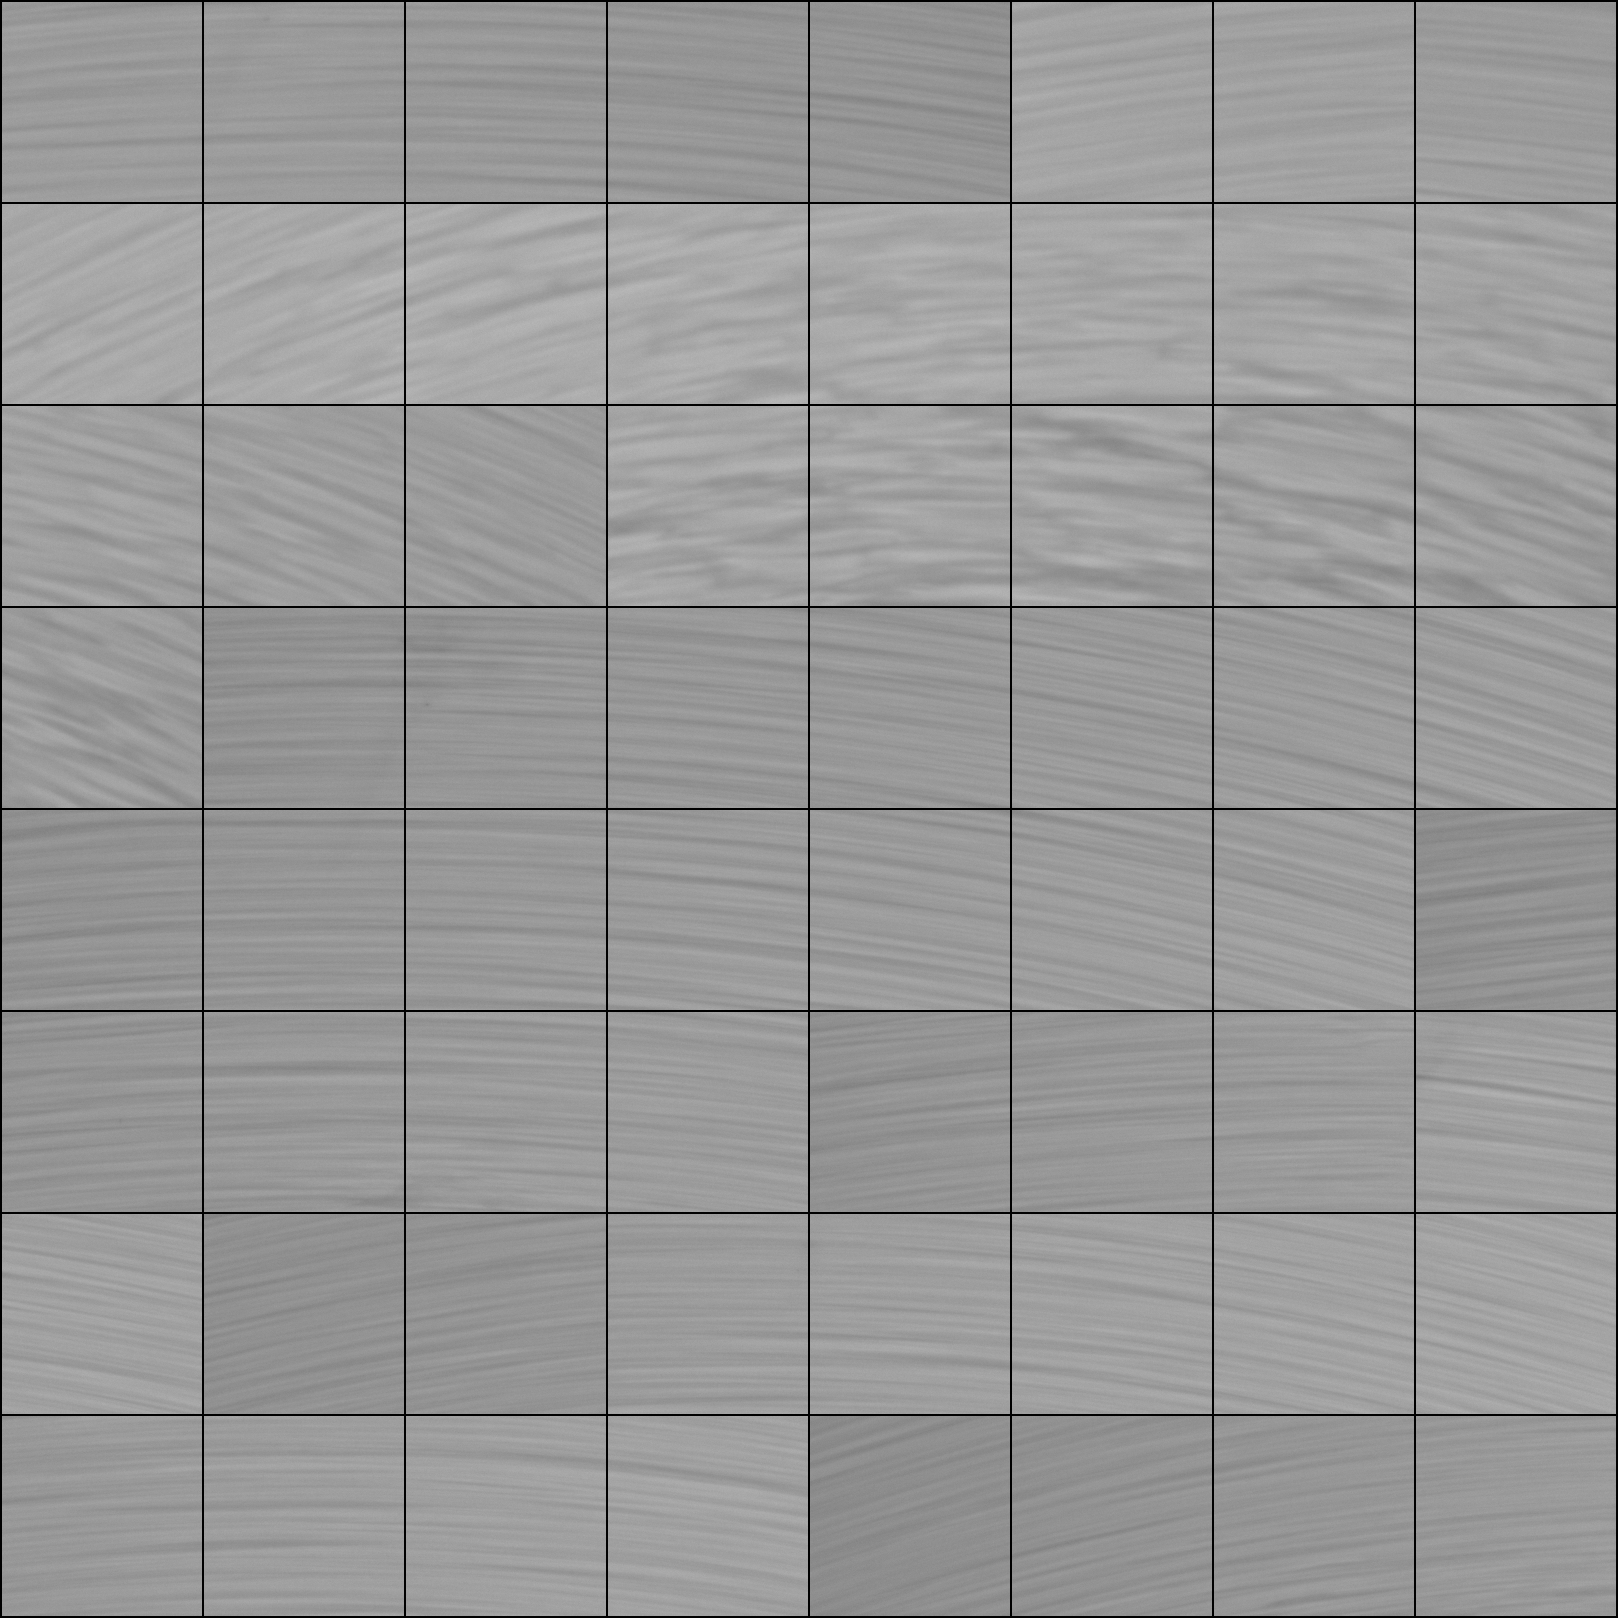

In [6]:
# Fixed input for debugging
fixed_x, _ = next(iter(train_dataloader))
save_image(fixed_x, 'fiber_image200_pattern1.png')
Image('fiber_image200_pattern1.png')

In [7]:
dataloader_iterator = iter(train_dataloader)
for i in range(len(train_dataloader)):
    try:
        data, target = next(dataloader_iterator)
        save_image(data, './Fiber/Original/Pattern1/image_{}.png'.format(i))
    except StopIteration:
        dataloader_iterator = iter(dataloader)
        data, target = next(dataloader_iterator)

In [3]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [4]:
class UnFlatten(nn.Module):
    def forward(self, input, size=200):
        return input.view(input.size(0), size, 1, 1)

In [5]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(128, 200, kernel_size=2, stride=2),
            nn.BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(200, 200, kernel_size=2, stride=2),
            nn.BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(200, 200, kernel_size=2, stride=2),
            nn.BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(200, 200, kernel_size=2, stride=2),
            nn.BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            Flatten()
        )
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(200, 128, kernel_size=3, stride=2),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2),
            nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [6]:
model= autoencoder()
model.to(device)

autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(128, 200, kernel_size=(2, 2), stride=(2, 2))
    (10): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(200, 200, kernel_size=(2, 2), stride=(2, 2))
    (13): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Conv2d(200, 200, kernel_size=(2, 2), stride=(2, 2))
    (16): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, tra

In [12]:
## show input shape
summary(model,(3,200,200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 100, 100]             416
       BatchNorm2d-2         [-1, 32, 100, 100]              64
              ReLU-3         [-1, 32, 100, 100]               0
            Conv2d-4           [-1, 64, 50, 50]           8,256
       BatchNorm2d-5           [-1, 64, 50, 50]             128
              ReLU-6           [-1, 64, 50, 50]               0
            Conv2d-7          [-1, 128, 25, 25]          32,896
       BatchNorm2d-8          [-1, 128, 25, 25]             256
              ReLU-9          [-1, 128, 25, 25]               0
           Conv2d-10          [-1, 200, 12, 12]         102,600
      BatchNorm2d-11          [-1, 200, 12, 12]             400
             ReLU-12          [-1, 200, 12, 12]               0
           Conv2d-13            [-1, 200, 6, 6]         160,200
      BatchNorm2d-14            [-1, 20

In [7]:
def to_img(x):
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 3, 200, 200)
    return x

In [8]:
num_epochs = 2000
learning_rate = 1e-3
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [12]:
for epoch in range(num_epochs):
    for data in train_dataloader:
        img, _ = data
        img = Variable(img).cuda()
        # ===================forward=====================
        output = model(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.data))
    tb.add_scalar("Loss/Epoch", loss.data, epoch+1)
    if epoch % 10 == 0:
        pic = to_img(output.cpu().data)
        save_image(pic, './Fiber/Reconstructed/Smaller_Train/image_{}.png'.format(epoch))

torch.save(model.state_dict(), './autoencoder_fiber_smaller_pattern1.pth')

epoch [1/2000], loss:0.0509
epoch [1/2000], loss:0.0290
epoch [1/2000], loss:0.0270
epoch [1/2000], loss:0.0175
epoch [1/2000], loss:0.0247
epoch [1/2000], loss:0.0178
epoch [1/2000], loss:0.0193
epoch [1/2000], loss:0.0197
epoch [2/2000], loss:0.0153
epoch [2/2000], loss:0.0137
epoch [2/2000], loss:0.0152
epoch [2/2000], loss:0.0121
epoch [2/2000], loss:0.0191
epoch [2/2000], loss:0.0135
epoch [2/2000], loss:0.0145
epoch [2/2000], loss:0.0159
epoch [3/2000], loss:0.0125
epoch [3/2000], loss:0.0121
epoch [3/2000], loss:0.0131
epoch [3/2000], loss:0.0107
epoch [3/2000], loss:0.0175
epoch [3/2000], loss:0.0123
epoch [3/2000], loss:0.0130
epoch [3/2000], loss:0.0147
epoch [4/2000], loss:0.0114
epoch [4/2000], loss:0.0113
epoch [4/2000], loss:0.0122
epoch [4/2000], loss:0.0101
epoch [4/2000], loss:0.0166
epoch [4/2000], loss:0.0115
epoch [4/2000], loss:0.0122
epoch [4/2000], loss:0.0138
epoch [5/2000], loss:0.0108
epoch [5/2000], loss:0.0107
epoch [5/2000], loss:0.0116
epoch [5/2000], loss

epoch [36/2000], loss:0.0039
epoch [36/2000], loss:0.0045
epoch [36/2000], loss:0.0054
epoch [37/2000], loss:0.0036
epoch [37/2000], loss:0.0036
epoch [37/2000], loss:0.0042
epoch [37/2000], loss:0.0035
epoch [37/2000], loss:0.0062
epoch [37/2000], loss:0.0038
epoch [37/2000], loss:0.0041
epoch [37/2000], loss:0.0054
epoch [38/2000], loss:0.0036
epoch [38/2000], loss:0.0035
epoch [38/2000], loss:0.0038
epoch [38/2000], loss:0.0034
epoch [38/2000], loss:0.0067
epoch [38/2000], loss:0.0037
epoch [38/2000], loss:0.0043
epoch [38/2000], loss:0.0052
epoch [39/2000], loss:0.0033
epoch [39/2000], loss:0.0034
epoch [39/2000], loss:0.0041
epoch [39/2000], loss:0.0036
epoch [39/2000], loss:0.0058
epoch [39/2000], loss:0.0036
epoch [39/2000], loss:0.0042
epoch [39/2000], loss:0.0050
epoch [40/2000], loss:0.0031
epoch [40/2000], loss:0.0033
epoch [40/2000], loss:0.0039
epoch [40/2000], loss:0.0032
epoch [40/2000], loss:0.0056
epoch [40/2000], loss:0.0035
epoch [40/2000], loss:0.0041
epoch [40/2000

epoch [72/2000], loss:0.0015
epoch [72/2000], loss:0.0013
epoch [72/2000], loss:0.0026
epoch [72/2000], loss:0.0019
epoch [72/2000], loss:0.0031
epoch [72/2000], loss:0.0018
epoch [72/2000], loss:0.0023
epoch [72/2000], loss:0.0027
epoch [73/2000], loss:0.0018
epoch [73/2000], loss:0.0014
epoch [73/2000], loss:0.0023
epoch [73/2000], loss:0.0022
epoch [73/2000], loss:0.0027
epoch [73/2000], loss:0.0016
epoch [73/2000], loss:0.0025
epoch [73/2000], loss:0.0027
epoch [74/2000], loss:0.0016
epoch [74/2000], loss:0.0015
epoch [74/2000], loss:0.0018
epoch [74/2000], loss:0.0020
epoch [74/2000], loss:0.0026
epoch [74/2000], loss:0.0015
epoch [74/2000], loss:0.0018
epoch [74/2000], loss:0.0024
epoch [75/2000], loss:0.0015
epoch [75/2000], loss:0.0014
epoch [75/2000], loss:0.0017
epoch [75/2000], loss:0.0017
epoch [75/2000], loss:0.0026
epoch [75/2000], loss:0.0014
epoch [75/2000], loss:0.0020
epoch [75/2000], loss:0.0022
epoch [76/2000], loss:0.0014
epoch [76/2000], loss:0.0014
epoch [76/2000

epoch [107/2000], loss:0.0007
epoch [107/2000], loss:0.0009
epoch [107/2000], loss:0.0014
epoch [107/2000], loss:0.0014
epoch [107/2000], loss:0.0006
epoch [107/2000], loss:0.0008
epoch [107/2000], loss:0.0011
epoch [108/2000], loss:0.0005
epoch [108/2000], loss:0.0007
epoch [108/2000], loss:0.0009
epoch [108/2000], loss:0.0014
epoch [108/2000], loss:0.0013
epoch [108/2000], loss:0.0006
epoch [108/2000], loss:0.0008
epoch [108/2000], loss:0.0011
epoch [109/2000], loss:0.0005
epoch [109/2000], loss:0.0007
epoch [109/2000], loss:0.0009
epoch [109/2000], loss:0.0014
epoch [109/2000], loss:0.0014
epoch [109/2000], loss:0.0006
epoch [109/2000], loss:0.0008
epoch [109/2000], loss:0.0011
epoch [110/2000], loss:0.0005
epoch [110/2000], loss:0.0008
epoch [110/2000], loss:0.0009
epoch [110/2000], loss:0.0014
epoch [110/2000], loss:0.0014
epoch [110/2000], loss:0.0006
epoch [110/2000], loss:0.0008
epoch [110/2000], loss:0.0011
epoch [111/2000], loss:0.0005
epoch [111/2000], loss:0.0008
epoch [111

epoch [141/2000], loss:0.0011
epoch [141/2000], loss:0.0010
epoch [141/2000], loss:0.0004
epoch [141/2000], loss:0.0005
epoch [141/2000], loss:0.0008
epoch [142/2000], loss:0.0004
epoch [142/2000], loss:0.0006
epoch [142/2000], loss:0.0007
epoch [142/2000], loss:0.0011
epoch [142/2000], loss:0.0010
epoch [142/2000], loss:0.0004
epoch [142/2000], loss:0.0005
epoch [142/2000], loss:0.0008
epoch [143/2000], loss:0.0004
epoch [143/2000], loss:0.0006
epoch [143/2000], loss:0.0007
epoch [143/2000], loss:0.0011
epoch [143/2000], loss:0.0010
epoch [143/2000], loss:0.0004
epoch [143/2000], loss:0.0005
epoch [143/2000], loss:0.0007
epoch [144/2000], loss:0.0004
epoch [144/2000], loss:0.0006
epoch [144/2000], loss:0.0007
epoch [144/2000], loss:0.0011
epoch [144/2000], loss:0.0010
epoch [144/2000], loss:0.0004
epoch [144/2000], loss:0.0005
epoch [144/2000], loss:0.0007
epoch [145/2000], loss:0.0003
epoch [145/2000], loss:0.0006
epoch [145/2000], loss:0.0007
epoch [145/2000], loss:0.0011
epoch [145

epoch [175/2000], loss:0.0005
epoch [175/2000], loss:0.0007
epoch [175/2000], loss:0.0010
epoch [176/2000], loss:0.0005
epoch [176/2000], loss:0.0007
epoch [176/2000], loss:0.0010
epoch [176/2000], loss:0.0016
epoch [176/2000], loss:0.0010
epoch [176/2000], loss:0.0005
epoch [176/2000], loss:0.0007
epoch [176/2000], loss:0.0010
epoch [177/2000], loss:0.0005
epoch [177/2000], loss:0.0007
epoch [177/2000], loss:0.0010
epoch [177/2000], loss:0.0016
epoch [177/2000], loss:0.0010
epoch [177/2000], loss:0.0005
epoch [177/2000], loss:0.0007
epoch [177/2000], loss:0.0010
epoch [178/2000], loss:0.0004
epoch [178/2000], loss:0.0007
epoch [178/2000], loss:0.0010
epoch [178/2000], loss:0.0016
epoch [178/2000], loss:0.0010
epoch [178/2000], loss:0.0005
epoch [178/2000], loss:0.0007
epoch [178/2000], loss:0.0010
epoch [179/2000], loss:0.0004
epoch [179/2000], loss:0.0007
epoch [179/2000], loss:0.0010
epoch [179/2000], loss:0.0016
epoch [179/2000], loss:0.0010
epoch [179/2000], loss:0.0005
epoch [179

epoch [210/2000], loss:0.0004
epoch [210/2000], loss:0.0007
epoch [210/2000], loss:0.0008
epoch [210/2000], loss:0.0015
epoch [210/2000], loss:0.0010
epoch [210/2000], loss:0.0005
epoch [210/2000], loss:0.0006
epoch [210/2000], loss:0.0009
epoch [211/2000], loss:0.0004
epoch [211/2000], loss:0.0007
epoch [211/2000], loss:0.0008
epoch [211/2000], loss:0.0014
epoch [211/2000], loss:0.0010
epoch [211/2000], loss:0.0005
epoch [211/2000], loss:0.0006
epoch [211/2000], loss:0.0009
epoch [212/2000], loss:0.0004
epoch [212/2000], loss:0.0007
epoch [212/2000], loss:0.0008
epoch [212/2000], loss:0.0014
epoch [212/2000], loss:0.0010
epoch [212/2000], loss:0.0005
epoch [212/2000], loss:0.0006
epoch [212/2000], loss:0.0009
epoch [213/2000], loss:0.0004
epoch [213/2000], loss:0.0007
epoch [213/2000], loss:0.0008
epoch [213/2000], loss:0.0014
epoch [213/2000], loss:0.0010
epoch [213/2000], loss:0.0005
epoch [213/2000], loss:0.0006
epoch [213/2000], loss:0.0009
epoch [214/2000], loss:0.0004
epoch [214

epoch [244/2000], loss:0.0007
epoch [244/2000], loss:0.0012
epoch [244/2000], loss:0.0010
epoch [244/2000], loss:0.0004
epoch [244/2000], loss:0.0006
epoch [244/2000], loss:0.0008
epoch [245/2000], loss:0.0004
epoch [245/2000], loss:0.0006
epoch [245/2000], loss:0.0007
epoch [245/2000], loss:0.0012
epoch [245/2000], loss:0.0010
epoch [245/2000], loss:0.0004
epoch [245/2000], loss:0.0006
epoch [245/2000], loss:0.0008
epoch [246/2000], loss:0.0004
epoch [246/2000], loss:0.0006
epoch [246/2000], loss:0.0007
epoch [246/2000], loss:0.0012
epoch [246/2000], loss:0.0010
epoch [246/2000], loss:0.0004
epoch [246/2000], loss:0.0006
epoch [246/2000], loss:0.0008
epoch [247/2000], loss:0.0004
epoch [247/2000], loss:0.0006
epoch [247/2000], loss:0.0007
epoch [247/2000], loss:0.0012
epoch [247/2000], loss:0.0010
epoch [247/2000], loss:0.0004
epoch [247/2000], loss:0.0005
epoch [247/2000], loss:0.0008
epoch [248/2000], loss:0.0004
epoch [248/2000], loss:0.0006
epoch [248/2000], loss:0.0007
epoch [248

epoch [278/2000], loss:0.0004
epoch [278/2000], loss:0.0005
epoch [278/2000], loss:0.0007
epoch [279/2000], loss:0.0003
epoch [279/2000], loss:0.0006
epoch [279/2000], loss:0.0006
epoch [279/2000], loss:0.0010
epoch [279/2000], loss:0.0009
epoch [279/2000], loss:0.0004
epoch [279/2000], loss:0.0005
epoch [279/2000], loss:0.0007
epoch [280/2000], loss:0.0003
epoch [280/2000], loss:0.0006
epoch [280/2000], loss:0.0006
epoch [280/2000], loss:0.0010
epoch [280/2000], loss:0.0009
epoch [280/2000], loss:0.0004
epoch [280/2000], loss:0.0005
epoch [280/2000], loss:0.0007
epoch [281/2000], loss:0.0003
epoch [281/2000], loss:0.0006
epoch [281/2000], loss:0.0006
epoch [281/2000], loss:0.0010
epoch [281/2000], loss:0.0009
epoch [281/2000], loss:0.0004
epoch [281/2000], loss:0.0005
epoch [281/2000], loss:0.0007
epoch [282/2000], loss:0.0003
epoch [282/2000], loss:0.0005
epoch [282/2000], loss:0.0006
epoch [282/2000], loss:0.0010
epoch [282/2000], loss:0.0009
epoch [282/2000], loss:0.0004
epoch [282

epoch [312/2000], loss:0.0006
epoch [313/2000], loss:0.0003
epoch [313/2000], loss:0.0005
epoch [313/2000], loss:0.0005
epoch [313/2000], loss:0.0009
epoch [313/2000], loss:0.0009
epoch [313/2000], loss:0.0004
epoch [313/2000], loss:0.0004
epoch [313/2000], loss:0.0006
epoch [314/2000], loss:0.0003
epoch [314/2000], loss:0.0005
epoch [314/2000], loss:0.0005
epoch [314/2000], loss:0.0009
epoch [314/2000], loss:0.0009
epoch [314/2000], loss:0.0003
epoch [314/2000], loss:0.0004
epoch [314/2000], loss:0.0006
epoch [315/2000], loss:0.0003
epoch [315/2000], loss:0.0005
epoch [315/2000], loss:0.0005
epoch [315/2000], loss:0.0008
epoch [315/2000], loss:0.0009
epoch [315/2000], loss:0.0003
epoch [315/2000], loss:0.0004
epoch [315/2000], loss:0.0005
epoch [316/2000], loss:0.0003
epoch [316/2000], loss:0.0005
epoch [316/2000], loss:0.0005
epoch [316/2000], loss:0.0008
epoch [316/2000], loss:0.0009
epoch [316/2000], loss:0.0003
epoch [316/2000], loss:0.0004
epoch [316/2000], loss:0.0005
epoch [317

epoch [347/2000], loss:0.0004
epoch [347/2000], loss:0.0004
epoch [347/2000], loss:0.0007
epoch [347/2000], loss:0.0008
epoch [347/2000], loss:0.0003
epoch [347/2000], loss:0.0003
epoch [347/2000], loss:0.0005
epoch [348/2000], loss:0.0003
epoch [348/2000], loss:0.0004
epoch [348/2000], loss:0.0004
epoch [348/2000], loss:0.0007
epoch [348/2000], loss:0.0008
epoch [348/2000], loss:0.0003
epoch [348/2000], loss:0.0003
epoch [348/2000], loss:0.0005
epoch [349/2000], loss:0.0003
epoch [349/2000], loss:0.0004
epoch [349/2000], loss:0.0004
epoch [349/2000], loss:0.0008
epoch [349/2000], loss:0.0008
epoch [349/2000], loss:0.0003
epoch [349/2000], loss:0.0003
epoch [349/2000], loss:0.0005
epoch [350/2000], loss:0.0003
epoch [350/2000], loss:0.0004
epoch [350/2000], loss:0.0004
epoch [350/2000], loss:0.0007
epoch [350/2000], loss:0.0008
epoch [350/2000], loss:0.0003
epoch [350/2000], loss:0.0003
epoch [350/2000], loss:0.0005
epoch [351/2000], loss:0.0003
epoch [351/2000], loss:0.0004
epoch [351

epoch [381/2000], loss:0.0007
epoch [381/2000], loss:0.0008
epoch [381/2000], loss:0.0003
epoch [381/2000], loss:0.0003
epoch [381/2000], loss:0.0004
epoch [382/2000], loss:0.0002
epoch [382/2000], loss:0.0004
epoch [382/2000], loss:0.0004
epoch [382/2000], loss:0.0007
epoch [382/2000], loss:0.0008
epoch [382/2000], loss:0.0003
epoch [382/2000], loss:0.0003
epoch [382/2000], loss:0.0004
epoch [383/2000], loss:0.0002
epoch [383/2000], loss:0.0004
epoch [383/2000], loss:0.0004
epoch [383/2000], loss:0.0007
epoch [383/2000], loss:0.0008
epoch [383/2000], loss:0.0003
epoch [383/2000], loss:0.0003
epoch [383/2000], loss:0.0005
epoch [384/2000], loss:0.0002
epoch [384/2000], loss:0.0004
epoch [384/2000], loss:0.0004
epoch [384/2000], loss:0.0007
epoch [384/2000], loss:0.0008
epoch [384/2000], loss:0.0003
epoch [384/2000], loss:0.0003
epoch [384/2000], loss:0.0005
epoch [385/2000], loss:0.0003
epoch [385/2000], loss:0.0004
epoch [385/2000], loss:0.0004
epoch [385/2000], loss:0.0007
epoch [385

epoch [415/2000], loss:0.0003
epoch [415/2000], loss:0.0003
epoch [415/2000], loss:0.0005
epoch [416/2000], loss:0.0003
epoch [416/2000], loss:0.0004
epoch [416/2000], loss:0.0004
epoch [416/2000], loss:0.0007
epoch [416/2000], loss:0.0008
epoch [416/2000], loss:0.0003
epoch [416/2000], loss:0.0003
epoch [416/2000], loss:0.0005
epoch [417/2000], loss:0.0002
epoch [417/2000], loss:0.0004
epoch [417/2000], loss:0.0004
epoch [417/2000], loss:0.0007
epoch [417/2000], loss:0.0008
epoch [417/2000], loss:0.0003
epoch [417/2000], loss:0.0003
epoch [417/2000], loss:0.0004
epoch [418/2000], loss:0.0002
epoch [418/2000], loss:0.0004
epoch [418/2000], loss:0.0004
epoch [418/2000], loss:0.0007
epoch [418/2000], loss:0.0008
epoch [418/2000], loss:0.0003
epoch [418/2000], loss:0.0003
epoch [418/2000], loss:0.0004
epoch [419/2000], loss:0.0002
epoch [419/2000], loss:0.0004
epoch [419/2000], loss:0.0004
epoch [419/2000], loss:0.0007
epoch [419/2000], loss:0.0008
epoch [419/2000], loss:0.0003
epoch [419

epoch [449/2000], loss:0.0004
epoch [450/2000], loss:0.0002
epoch [450/2000], loss:0.0004
epoch [450/2000], loss:0.0004
epoch [450/2000], loss:0.0006
epoch [450/2000], loss:0.0008
epoch [450/2000], loss:0.0002
epoch [450/2000], loss:0.0003
epoch [450/2000], loss:0.0004
epoch [451/2000], loss:0.0002
epoch [451/2000], loss:0.0003
epoch [451/2000], loss:0.0004
epoch [451/2000], loss:0.0006
epoch [451/2000], loss:0.0008
epoch [451/2000], loss:0.0003
epoch [451/2000], loss:0.0003
epoch [451/2000], loss:0.0004
epoch [452/2000], loss:0.0002
epoch [452/2000], loss:0.0003
epoch [452/2000], loss:0.0003
epoch [452/2000], loss:0.0006
epoch [452/2000], loss:0.0008
epoch [452/2000], loss:0.0002
epoch [452/2000], loss:0.0003
epoch [452/2000], loss:0.0004
epoch [453/2000], loss:0.0002
epoch [453/2000], loss:0.0003
epoch [453/2000], loss:0.0003
epoch [453/2000], loss:0.0006
epoch [453/2000], loss:0.0008
epoch [453/2000], loss:0.0002
epoch [453/2000], loss:0.0003
epoch [453/2000], loss:0.0004
epoch [454

epoch [484/2000], loss:0.0003
epoch [484/2000], loss:0.0003
epoch [484/2000], loss:0.0006
epoch [484/2000], loss:0.0007
epoch [484/2000], loss:0.0002
epoch [484/2000], loss:0.0003
epoch [484/2000], loss:0.0004
epoch [485/2000], loss:0.0002
epoch [485/2000], loss:0.0003
epoch [485/2000], loss:0.0003
epoch [485/2000], loss:0.0006
epoch [485/2000], loss:0.0007
epoch [485/2000], loss:0.0002
epoch [485/2000], loss:0.0003
epoch [485/2000], loss:0.0004
epoch [486/2000], loss:0.0002
epoch [486/2000], loss:0.0003
epoch [486/2000], loss:0.0003
epoch [486/2000], loss:0.0006
epoch [486/2000], loss:0.0008
epoch [486/2000], loss:0.0002
epoch [486/2000], loss:0.0002
epoch [486/2000], loss:0.0004
epoch [487/2000], loss:0.0002
epoch [487/2000], loss:0.0003
epoch [487/2000], loss:0.0003
epoch [487/2000], loss:0.0006
epoch [487/2000], loss:0.0008
epoch [487/2000], loss:0.0002
epoch [487/2000], loss:0.0003
epoch [487/2000], loss:0.0004
epoch [488/2000], loss:0.0002
epoch [488/2000], loss:0.0003
epoch [488

epoch [518/2000], loss:0.0006
epoch [518/2000], loss:0.0007
epoch [518/2000], loss:0.0002
epoch [518/2000], loss:0.0002
epoch [518/2000], loss:0.0004
epoch [519/2000], loss:0.0002
epoch [519/2000], loss:0.0003
epoch [519/2000], loss:0.0003
epoch [519/2000], loss:0.0006
epoch [519/2000], loss:0.0007
epoch [519/2000], loss:0.0002
epoch [519/2000], loss:0.0003
epoch [519/2000], loss:0.0004
epoch [520/2000], loss:0.0002
epoch [520/2000], loss:0.0003
epoch [520/2000], loss:0.0003
epoch [520/2000], loss:0.0006
epoch [520/2000], loss:0.0007
epoch [520/2000], loss:0.0002
epoch [520/2000], loss:0.0002
epoch [520/2000], loss:0.0004
epoch [521/2000], loss:0.0002
epoch [521/2000], loss:0.0003
epoch [521/2000], loss:0.0003
epoch [521/2000], loss:0.0006
epoch [521/2000], loss:0.0007
epoch [521/2000], loss:0.0002
epoch [521/2000], loss:0.0002
epoch [521/2000], loss:0.0004
epoch [522/2000], loss:0.0002
epoch [522/2000], loss:0.0003
epoch [522/2000], loss:0.0003
epoch [522/2000], loss:0.0006
epoch [522

epoch [552/2000], loss:0.0002
epoch [552/2000], loss:0.0002
epoch [552/2000], loss:0.0004
epoch [553/2000], loss:0.0002
epoch [553/2000], loss:0.0003
epoch [553/2000], loss:0.0003
epoch [553/2000], loss:0.0006
epoch [553/2000], loss:0.0008
epoch [553/2000], loss:0.0002
epoch [553/2000], loss:0.0002
epoch [553/2000], loss:0.0004
epoch [554/2000], loss:0.0002
epoch [554/2000], loss:0.0003
epoch [554/2000], loss:0.0003
epoch [554/2000], loss:0.0006
epoch [554/2000], loss:0.0007
epoch [554/2000], loss:0.0002
epoch [554/2000], loss:0.0002
epoch [554/2000], loss:0.0004
epoch [555/2000], loss:0.0002
epoch [555/2000], loss:0.0003
epoch [555/2000], loss:0.0003
epoch [555/2000], loss:0.0006
epoch [555/2000], loss:0.0007
epoch [555/2000], loss:0.0002
epoch [555/2000], loss:0.0002
epoch [555/2000], loss:0.0004
epoch [556/2000], loss:0.0002
epoch [556/2000], loss:0.0003
epoch [556/2000], loss:0.0003
epoch [556/2000], loss:0.0006
epoch [556/2000], loss:0.0007
epoch [556/2000], loss:0.0002
epoch [556

epoch [586/2000], loss:0.0004
epoch [587/2000], loss:0.0002
epoch [587/2000], loss:0.0003
epoch [587/2000], loss:0.0003
epoch [587/2000], loss:0.0006
epoch [587/2000], loss:0.0007
epoch [587/2000], loss:0.0002
epoch [587/2000], loss:0.0002
epoch [587/2000], loss:0.0004
epoch [588/2000], loss:0.0002
epoch [588/2000], loss:0.0003
epoch [588/2000], loss:0.0003
epoch [588/2000], loss:0.0006
epoch [588/2000], loss:0.0007
epoch [588/2000], loss:0.0002
epoch [588/2000], loss:0.0002
epoch [588/2000], loss:0.0004
epoch [589/2000], loss:0.0002
epoch [589/2000], loss:0.0003
epoch [589/2000], loss:0.0003
epoch [589/2000], loss:0.0006
epoch [589/2000], loss:0.0007
epoch [589/2000], loss:0.0002
epoch [589/2000], loss:0.0002
epoch [589/2000], loss:0.0004
epoch [590/2000], loss:0.0002
epoch [590/2000], loss:0.0003
epoch [590/2000], loss:0.0003
epoch [590/2000], loss:0.0005
epoch [590/2000], loss:0.0007
epoch [590/2000], loss:0.0002
epoch [590/2000], loss:0.0002
epoch [590/2000], loss:0.0004
epoch [591

epoch [621/2000], loss:0.0003
epoch [621/2000], loss:0.0003
epoch [621/2000], loss:0.0005
epoch [621/2000], loss:0.0007
epoch [621/2000], loss:0.0002
epoch [621/2000], loss:0.0002
epoch [621/2000], loss:0.0003
epoch [622/2000], loss:0.0002
epoch [622/2000], loss:0.0003
epoch [622/2000], loss:0.0003
epoch [622/2000], loss:0.0005
epoch [622/2000], loss:0.0007
epoch [622/2000], loss:0.0002
epoch [622/2000], loss:0.0002
epoch [622/2000], loss:0.0003
epoch [623/2000], loss:0.0002
epoch [623/2000], loss:0.0003
epoch [623/2000], loss:0.0003
epoch [623/2000], loss:0.0005
epoch [623/2000], loss:0.0007
epoch [623/2000], loss:0.0002
epoch [623/2000], loss:0.0002
epoch [623/2000], loss:0.0003
epoch [624/2000], loss:0.0002
epoch [624/2000], loss:0.0003
epoch [624/2000], loss:0.0003
epoch [624/2000], loss:0.0005
epoch [624/2000], loss:0.0007
epoch [624/2000], loss:0.0002
epoch [624/2000], loss:0.0002
epoch [624/2000], loss:0.0004
epoch [625/2000], loss:0.0002
epoch [625/2000], loss:0.0003
epoch [625

epoch [655/2000], loss:0.0007
epoch [655/2000], loss:0.0002
epoch [655/2000], loss:0.0002
epoch [655/2000], loss:0.0004
epoch [656/2000], loss:0.0002
epoch [656/2000], loss:0.0003
epoch [656/2000], loss:0.0003
epoch [656/2000], loss:0.0005
epoch [656/2000], loss:0.0007
epoch [656/2000], loss:0.0002
epoch [656/2000], loss:0.0002
epoch [656/2000], loss:0.0004
epoch [657/2000], loss:0.0002
epoch [657/2000], loss:0.0003
epoch [657/2000], loss:0.0003
epoch [657/2000], loss:0.0005
epoch [657/2000], loss:0.0007
epoch [657/2000], loss:0.0002
epoch [657/2000], loss:0.0002
epoch [657/2000], loss:0.0003
epoch [658/2000], loss:0.0002
epoch [658/2000], loss:0.0003
epoch [658/2000], loss:0.0003
epoch [658/2000], loss:0.0005
epoch [658/2000], loss:0.0007
epoch [658/2000], loss:0.0002
epoch [658/2000], loss:0.0002
epoch [658/2000], loss:0.0003
epoch [659/2000], loss:0.0002
epoch [659/2000], loss:0.0003
epoch [659/2000], loss:0.0003
epoch [659/2000], loss:0.0005
epoch [659/2000], loss:0.0007
epoch [659

epoch [723/2000], loss:0.0003
epoch [724/2000], loss:0.0002
epoch [724/2000], loss:0.0003
epoch [724/2000], loss:0.0003
epoch [724/2000], loss:0.0006
epoch [724/2000], loss:0.0007
epoch [724/2000], loss:0.0002
epoch [724/2000], loss:0.0002
epoch [724/2000], loss:0.0003
epoch [725/2000], loss:0.0002
epoch [725/2000], loss:0.0003
epoch [725/2000], loss:0.0003
epoch [725/2000], loss:0.0005
epoch [725/2000], loss:0.0007
epoch [725/2000], loss:0.0002
epoch [725/2000], loss:0.0002
epoch [725/2000], loss:0.0004
epoch [726/2000], loss:0.0002
epoch [726/2000], loss:0.0003
epoch [726/2000], loss:0.0003
epoch [726/2000], loss:0.0005
epoch [726/2000], loss:0.0007
epoch [726/2000], loss:0.0002
epoch [726/2000], loss:0.0002
epoch [726/2000], loss:0.0003
epoch [727/2000], loss:0.0002
epoch [727/2000], loss:0.0003
epoch [727/2000], loss:0.0003
epoch [727/2000], loss:0.0005
epoch [727/2000], loss:0.0007
epoch [727/2000], loss:0.0002
epoch [727/2000], loss:0.0002
epoch [727/2000], loss:0.0003
epoch [728

epoch [758/2000], loss:0.0003
epoch [758/2000], loss:0.0003
epoch [758/2000], loss:0.0005
epoch [758/2000], loss:0.0007
epoch [758/2000], loss:0.0002
epoch [758/2000], loss:0.0002
epoch [758/2000], loss:0.0004
epoch [759/2000], loss:0.0002
epoch [759/2000], loss:0.0003
epoch [759/2000], loss:0.0003
epoch [759/2000], loss:0.0005
epoch [759/2000], loss:0.0007
epoch [759/2000], loss:0.0002
epoch [759/2000], loss:0.0002
epoch [759/2000], loss:0.0004
epoch [760/2000], loss:0.0002
epoch [760/2000], loss:0.0003
epoch [760/2000], loss:0.0003
epoch [760/2000], loss:0.0005
epoch [760/2000], loss:0.0007
epoch [760/2000], loss:0.0002
epoch [760/2000], loss:0.0002
epoch [760/2000], loss:0.0004
epoch [761/2000], loss:0.0002
epoch [761/2000], loss:0.0003
epoch [761/2000], loss:0.0003
epoch [761/2000], loss:0.0006
epoch [761/2000], loss:0.0007
epoch [761/2000], loss:0.0002
epoch [761/2000], loss:0.0002
epoch [761/2000], loss:0.0003
epoch [762/2000], loss:0.0002
epoch [762/2000], loss:0.0003
epoch [762

epoch [792/2000], loss:0.0005
epoch [792/2000], loss:0.0007
epoch [792/2000], loss:0.0002
epoch [792/2000], loss:0.0002
epoch [792/2000], loss:0.0003
epoch [793/2000], loss:0.0002
epoch [793/2000], loss:0.0003
epoch [793/2000], loss:0.0003
epoch [793/2000], loss:0.0005
epoch [793/2000], loss:0.0007
epoch [793/2000], loss:0.0002
epoch [793/2000], loss:0.0002
epoch [793/2000], loss:0.0003
epoch [794/2000], loss:0.0002
epoch [794/2000], loss:0.0003
epoch [794/2000], loss:0.0003
epoch [794/2000], loss:0.0005
epoch [794/2000], loss:0.0007
epoch [794/2000], loss:0.0002
epoch [794/2000], loss:0.0002
epoch [794/2000], loss:0.0003
epoch [795/2000], loss:0.0002
epoch [795/2000], loss:0.0003
epoch [795/2000], loss:0.0003
epoch [795/2000], loss:0.0005
epoch [795/2000], loss:0.0007
epoch [795/2000], loss:0.0002
epoch [795/2000], loss:0.0002
epoch [795/2000], loss:0.0003
epoch [796/2000], loss:0.0002
epoch [796/2000], loss:0.0003
epoch [796/2000], loss:0.0003
epoch [796/2000], loss:0.0005
epoch [796

epoch [826/2000], loss:0.0002
epoch [826/2000], loss:0.0002
epoch [826/2000], loss:0.0003
epoch [827/2000], loss:0.0002
epoch [827/2000], loss:0.0003
epoch [827/2000], loss:0.0002
epoch [827/2000], loss:0.0005
epoch [827/2000], loss:0.0007
epoch [827/2000], loss:0.0002
epoch [827/2000], loss:0.0002
epoch [827/2000], loss:0.0003
epoch [828/2000], loss:0.0002
epoch [828/2000], loss:0.0003
epoch [828/2000], loss:0.0002
epoch [828/2000], loss:0.0005
epoch [828/2000], loss:0.0007
epoch [828/2000], loss:0.0002
epoch [828/2000], loss:0.0002
epoch [828/2000], loss:0.0003
epoch [829/2000], loss:0.0002
epoch [829/2000], loss:0.0003
epoch [829/2000], loss:0.0003
epoch [829/2000], loss:0.0005
epoch [829/2000], loss:0.0007
epoch [829/2000], loss:0.0002
epoch [829/2000], loss:0.0002
epoch [829/2000], loss:0.0003
epoch [830/2000], loss:0.0002
epoch [830/2000], loss:0.0003
epoch [830/2000], loss:0.0003
epoch [830/2000], loss:0.0005
epoch [830/2000], loss:0.0007
epoch [830/2000], loss:0.0002
epoch [830

epoch [860/2000], loss:0.0003
epoch [861/2000], loss:0.0002
epoch [861/2000], loss:0.0003
epoch [861/2000], loss:0.0003
epoch [861/2000], loss:0.0005
epoch [861/2000], loss:0.0007
epoch [861/2000], loss:0.0002
epoch [861/2000], loss:0.0002
epoch [861/2000], loss:0.0003
epoch [862/2000], loss:0.0002
epoch [862/2000], loss:0.0003
epoch [862/2000], loss:0.0003
epoch [862/2000], loss:0.0005
epoch [862/2000], loss:0.0007
epoch [862/2000], loss:0.0002
epoch [862/2000], loss:0.0002
epoch [862/2000], loss:0.0003
epoch [863/2000], loss:0.0002
epoch [863/2000], loss:0.0003
epoch [863/2000], loss:0.0003
epoch [863/2000], loss:0.0005
epoch [863/2000], loss:0.0007
epoch [863/2000], loss:0.0002
epoch [863/2000], loss:0.0002
epoch [863/2000], loss:0.0003
epoch [864/2000], loss:0.0002
epoch [864/2000], loss:0.0003
epoch [864/2000], loss:0.0003
epoch [864/2000], loss:0.0005
epoch [864/2000], loss:0.0007
epoch [864/2000], loss:0.0002
epoch [864/2000], loss:0.0002
epoch [864/2000], loss:0.0003
epoch [865

epoch [895/2000], loss:0.0003
epoch [895/2000], loss:0.0003
epoch [895/2000], loss:0.0005
epoch [895/2000], loss:0.0007
epoch [895/2000], loss:0.0002
epoch [895/2000], loss:0.0002
epoch [895/2000], loss:0.0003
epoch [896/2000], loss:0.0002
epoch [896/2000], loss:0.0003
epoch [896/2000], loss:0.0003
epoch [896/2000], loss:0.0005
epoch [896/2000], loss:0.0007
epoch [896/2000], loss:0.0002
epoch [896/2000], loss:0.0002
epoch [896/2000], loss:0.0003
epoch [897/2000], loss:0.0002
epoch [897/2000], loss:0.0003
epoch [897/2000], loss:0.0002
epoch [897/2000], loss:0.0005
epoch [897/2000], loss:0.0007
epoch [897/2000], loss:0.0002
epoch [897/2000], loss:0.0002
epoch [897/2000], loss:0.0003
epoch [898/2000], loss:0.0002
epoch [898/2000], loss:0.0003
epoch [898/2000], loss:0.0003
epoch [898/2000], loss:0.0005
epoch [898/2000], loss:0.0007
epoch [898/2000], loss:0.0002
epoch [898/2000], loss:0.0002
epoch [898/2000], loss:0.0003
epoch [899/2000], loss:0.0002
epoch [899/2000], loss:0.0003
epoch [899

epoch [929/2000], loss:0.0005
epoch [929/2000], loss:0.0007
epoch [929/2000], loss:0.0002
epoch [929/2000], loss:0.0002
epoch [929/2000], loss:0.0003
epoch [930/2000], loss:0.0002
epoch [930/2000], loss:0.0003
epoch [930/2000], loss:0.0003
epoch [930/2000], loss:0.0005
epoch [930/2000], loss:0.0007
epoch [930/2000], loss:0.0002
epoch [930/2000], loss:0.0002
epoch [930/2000], loss:0.0003
epoch [931/2000], loss:0.0002
epoch [931/2000], loss:0.0003
epoch [931/2000], loss:0.0003
epoch [931/2000], loss:0.0005
epoch [931/2000], loss:0.0007
epoch [931/2000], loss:0.0002
epoch [931/2000], loss:0.0002
epoch [931/2000], loss:0.0003
epoch [932/2000], loss:0.0002
epoch [932/2000], loss:0.0003
epoch [932/2000], loss:0.0003
epoch [932/2000], loss:0.0005
epoch [932/2000], loss:0.0007
epoch [932/2000], loss:0.0002
epoch [932/2000], loss:0.0002
epoch [932/2000], loss:0.0003
epoch [933/2000], loss:0.0002
epoch [933/2000], loss:0.0003
epoch [933/2000], loss:0.0003
epoch [933/2000], loss:0.0005
epoch [933

epoch [963/2000], loss:0.0002
epoch [963/2000], loss:0.0002
epoch [963/2000], loss:0.0003
epoch [964/2000], loss:0.0002
epoch [964/2000], loss:0.0003
epoch [964/2000], loss:0.0003
epoch [964/2000], loss:0.0005
epoch [964/2000], loss:0.0007
epoch [964/2000], loss:0.0002
epoch [964/2000], loss:0.0002
epoch [964/2000], loss:0.0003
epoch [965/2000], loss:0.0002
epoch [965/2000], loss:0.0003
epoch [965/2000], loss:0.0002
epoch [965/2000], loss:0.0005
epoch [965/2000], loss:0.0007
epoch [965/2000], loss:0.0002
epoch [965/2000], loss:0.0002
epoch [965/2000], loss:0.0003
epoch [966/2000], loss:0.0002
epoch [966/2000], loss:0.0003
epoch [966/2000], loss:0.0003
epoch [966/2000], loss:0.0005
epoch [966/2000], loss:0.0007
epoch [966/2000], loss:0.0002
epoch [966/2000], loss:0.0002
epoch [966/2000], loss:0.0003
epoch [967/2000], loss:0.0002
epoch [967/2000], loss:0.0003
epoch [967/2000], loss:0.0002
epoch [967/2000], loss:0.0005
epoch [967/2000], loss:0.0007
epoch [967/2000], loss:0.0002
epoch [967

epoch [997/2000], loss:0.0003
epoch [998/2000], loss:0.0002
epoch [998/2000], loss:0.0003
epoch [998/2000], loss:0.0003
epoch [998/2000], loss:0.0005
epoch [998/2000], loss:0.0007
epoch [998/2000], loss:0.0002
epoch [998/2000], loss:0.0002
epoch [998/2000], loss:0.0003
epoch [999/2000], loss:0.0002
epoch [999/2000], loss:0.0003
epoch [999/2000], loss:0.0003
epoch [999/2000], loss:0.0005
epoch [999/2000], loss:0.0007
epoch [999/2000], loss:0.0002
epoch [999/2000], loss:0.0002
epoch [999/2000], loss:0.0003
epoch [1000/2000], loss:0.0002
epoch [1000/2000], loss:0.0003
epoch [1000/2000], loss:0.0003
epoch [1000/2000], loss:0.0005
epoch [1000/2000], loss:0.0007
epoch [1000/2000], loss:0.0002
epoch [1000/2000], loss:0.0002
epoch [1000/2000], loss:0.0003
epoch [1001/2000], loss:0.0002
epoch [1001/2000], loss:0.0003
epoch [1001/2000], loss:0.0003
epoch [1001/2000], loss:0.0005
epoch [1001/2000], loss:0.0007
epoch [1001/2000], loss:0.0002
epoch [1001/2000], loss:0.0002
epoch [1001/2000], loss:0

epoch [1031/2000], loss:0.0002
epoch [1031/2000], loss:0.0003
epoch [1031/2000], loss:0.0003
epoch [1031/2000], loss:0.0005
epoch [1031/2000], loss:0.0007
epoch [1031/2000], loss:0.0002
epoch [1031/2000], loss:0.0002
epoch [1031/2000], loss:0.0003
epoch [1032/2000], loss:0.0002
epoch [1032/2000], loss:0.0003
epoch [1032/2000], loss:0.0002
epoch [1032/2000], loss:0.0005
epoch [1032/2000], loss:0.0007
epoch [1032/2000], loss:0.0002
epoch [1032/2000], loss:0.0002
epoch [1032/2000], loss:0.0003
epoch [1033/2000], loss:0.0002
epoch [1033/2000], loss:0.0003
epoch [1033/2000], loss:0.0002
epoch [1033/2000], loss:0.0005
epoch [1033/2000], loss:0.0007
epoch [1033/2000], loss:0.0002
epoch [1033/2000], loss:0.0002
epoch [1033/2000], loss:0.0003
epoch [1034/2000], loss:0.0002
epoch [1034/2000], loss:0.0003
epoch [1034/2000], loss:0.0003
epoch [1034/2000], loss:0.0005
epoch [1034/2000], loss:0.0007
epoch [1034/2000], loss:0.0002
epoch [1034/2000], loss:0.0002
epoch [1034/2000], loss:0.0003
epoch [1

epoch [1097/2000], loss:0.0003
epoch [1097/2000], loss:0.0003
epoch [1097/2000], loss:0.0006
epoch [1097/2000], loss:0.0007
epoch [1097/2000], loss:0.0002
epoch [1097/2000], loss:0.0002
epoch [1097/2000], loss:0.0004
epoch [1098/2000], loss:0.0002
epoch [1098/2000], loss:0.0003
epoch [1098/2000], loss:0.0003
epoch [1098/2000], loss:0.0006
epoch [1098/2000], loss:0.0007
epoch [1098/2000], loss:0.0002
epoch [1098/2000], loss:0.0002
epoch [1098/2000], loss:0.0004
epoch [1099/2000], loss:0.0002
epoch [1099/2000], loss:0.0003
epoch [1099/2000], loss:0.0003
epoch [1099/2000], loss:0.0006
epoch [1099/2000], loss:0.0007
epoch [1099/2000], loss:0.0002
epoch [1099/2000], loss:0.0002
epoch [1099/2000], loss:0.0004
epoch [1100/2000], loss:0.0002
epoch [1100/2000], loss:0.0003
epoch [1100/2000], loss:0.0003
epoch [1100/2000], loss:0.0006
epoch [1100/2000], loss:0.0007
epoch [1100/2000], loss:0.0002
epoch [1100/2000], loss:0.0002
epoch [1100/2000], loss:0.0004
epoch [1101/2000], loss:0.0002
epoch [1

epoch [1130/2000], loss:0.0003
epoch [1130/2000], loss:0.0005
epoch [1130/2000], loss:0.0007
epoch [1130/2000], loss:0.0002
epoch [1130/2000], loss:0.0002
epoch [1130/2000], loss:0.0003
epoch [1131/2000], loss:0.0002
epoch [1131/2000], loss:0.0003
epoch [1131/2000], loss:0.0003
epoch [1131/2000], loss:0.0005
epoch [1131/2000], loss:0.0007
epoch [1131/2000], loss:0.0002
epoch [1131/2000], loss:0.0002
epoch [1131/2000], loss:0.0003
epoch [1132/2000], loss:0.0002
epoch [1132/2000], loss:0.0003
epoch [1132/2000], loss:0.0003
epoch [1132/2000], loss:0.0005
epoch [1132/2000], loss:0.0007
epoch [1132/2000], loss:0.0002
epoch [1132/2000], loss:0.0002
epoch [1132/2000], loss:0.0003
epoch [1133/2000], loss:0.0002
epoch [1133/2000], loss:0.0003
epoch [1133/2000], loss:0.0003
epoch [1133/2000], loss:0.0005
epoch [1133/2000], loss:0.0007
epoch [1133/2000], loss:0.0002
epoch [1133/2000], loss:0.0002
epoch [1133/2000], loss:0.0003
epoch [1134/2000], loss:0.0002
epoch [1134/2000], loss:0.0003
epoch [1

epoch [1163/2000], loss:0.0005
epoch [1163/2000], loss:0.0007
epoch [1163/2000], loss:0.0002
epoch [1163/2000], loss:0.0002
epoch [1163/2000], loss:0.0003
epoch [1164/2000], loss:0.0002
epoch [1164/2000], loss:0.0003
epoch [1164/2000], loss:0.0003
epoch [1164/2000], loss:0.0005
epoch [1164/2000], loss:0.0007
epoch [1164/2000], loss:0.0002
epoch [1164/2000], loss:0.0002
epoch [1164/2000], loss:0.0004
epoch [1165/2000], loss:0.0002
epoch [1165/2000], loss:0.0003
epoch [1165/2000], loss:0.0003
epoch [1165/2000], loss:0.0006
epoch [1165/2000], loss:0.0007
epoch [1165/2000], loss:0.0002
epoch [1165/2000], loss:0.0002
epoch [1165/2000], loss:0.0003
epoch [1166/2000], loss:0.0002
epoch [1166/2000], loss:0.0003
epoch [1166/2000], loss:0.0003
epoch [1166/2000], loss:0.0006
epoch [1166/2000], loss:0.0007
epoch [1166/2000], loss:0.0002
epoch [1166/2000], loss:0.0002
epoch [1166/2000], loss:0.0004
epoch [1167/2000], loss:0.0002
epoch [1167/2000], loss:0.0003
epoch [1167/2000], loss:0.0003
epoch [1

epoch [1196/2000], loss:0.0007
epoch [1196/2000], loss:0.0002
epoch [1196/2000], loss:0.0002
epoch [1196/2000], loss:0.0003
epoch [1197/2000], loss:0.0002
epoch [1197/2000], loss:0.0003
epoch [1197/2000], loss:0.0003
epoch [1197/2000], loss:0.0005
epoch [1197/2000], loss:0.0007
epoch [1197/2000], loss:0.0002
epoch [1197/2000], loss:0.0002
epoch [1197/2000], loss:0.0003
epoch [1198/2000], loss:0.0002
epoch [1198/2000], loss:0.0003
epoch [1198/2000], loss:0.0003
epoch [1198/2000], loss:0.0005
epoch [1198/2000], loss:0.0007
epoch [1198/2000], loss:0.0002
epoch [1198/2000], loss:0.0002
epoch [1198/2000], loss:0.0003
epoch [1199/2000], loss:0.0002
epoch [1199/2000], loss:0.0003
epoch [1199/2000], loss:0.0003
epoch [1199/2000], loss:0.0005
epoch [1199/2000], loss:0.0007
epoch [1199/2000], loss:0.0002
epoch [1199/2000], loss:0.0002
epoch [1199/2000], loss:0.0003
epoch [1200/2000], loss:0.0002
epoch [1200/2000], loss:0.0003
epoch [1200/2000], loss:0.0003
epoch [1200/2000], loss:0.0005
epoch [1

epoch [1262/2000], loss:0.0002
epoch [1262/2000], loss:0.0002
epoch [1262/2000], loss:0.0003
epoch [1263/2000], loss:0.0002
epoch [1263/2000], loss:0.0003
epoch [1263/2000], loss:0.0003
epoch [1263/2000], loss:0.0005
epoch [1263/2000], loss:0.0007
epoch [1263/2000], loss:0.0002
epoch [1263/2000], loss:0.0002
epoch [1263/2000], loss:0.0003
epoch [1264/2000], loss:0.0002
epoch [1264/2000], loss:0.0003
epoch [1264/2000], loss:0.0003
epoch [1264/2000], loss:0.0005
epoch [1264/2000], loss:0.0007
epoch [1264/2000], loss:0.0002
epoch [1264/2000], loss:0.0002
epoch [1264/2000], loss:0.0003
epoch [1265/2000], loss:0.0002
epoch [1265/2000], loss:0.0003
epoch [1265/2000], loss:0.0003
epoch [1265/2000], loss:0.0005
epoch [1265/2000], loss:0.0007
epoch [1265/2000], loss:0.0002
epoch [1265/2000], loss:0.0002
epoch [1265/2000], loss:0.0003
epoch [1266/2000], loss:0.0002
epoch [1266/2000], loss:0.0003
epoch [1266/2000], loss:0.0003
epoch [1266/2000], loss:0.0005
epoch [1266/2000], loss:0.0007
epoch [1

epoch [1328/2000], loss:0.0002
epoch [1328/2000], loss:0.0003
epoch [1329/2000], loss:0.0002
epoch [1329/2000], loss:0.0003
epoch [1329/2000], loss:0.0003
epoch [1329/2000], loss:0.0005
epoch [1329/2000], loss:0.0007
epoch [1329/2000], loss:0.0002
epoch [1329/2000], loss:0.0002
epoch [1329/2000], loss:0.0003
epoch [1330/2000], loss:0.0002
epoch [1330/2000], loss:0.0003
epoch [1330/2000], loss:0.0002
epoch [1330/2000], loss:0.0005
epoch [1330/2000], loss:0.0007
epoch [1330/2000], loss:0.0002
epoch [1330/2000], loss:0.0002
epoch [1330/2000], loss:0.0003
epoch [1331/2000], loss:0.0002
epoch [1331/2000], loss:0.0003
epoch [1331/2000], loss:0.0003
epoch [1331/2000], loss:0.0005
epoch [1331/2000], loss:0.0007
epoch [1331/2000], loss:0.0002
epoch [1331/2000], loss:0.0002
epoch [1331/2000], loss:0.0004
epoch [1332/2000], loss:0.0002
epoch [1332/2000], loss:0.0003
epoch [1332/2000], loss:0.0003
epoch [1332/2000], loss:0.0005
epoch [1332/2000], loss:0.0007
epoch [1332/2000], loss:0.0002
epoch [1

epoch [1361/2000], loss:0.0003
epoch [1362/2000], loss:0.0002
epoch [1362/2000], loss:0.0003
epoch [1362/2000], loss:0.0003
epoch [1362/2000], loss:0.0006
epoch [1362/2000], loss:0.0007
epoch [1362/2000], loss:0.0002
epoch [1362/2000], loss:0.0002
epoch [1362/2000], loss:0.0004
epoch [1363/2000], loss:0.0002
epoch [1363/2000], loss:0.0003
epoch [1363/2000], loss:0.0003
epoch [1363/2000], loss:0.0005
epoch [1363/2000], loss:0.0007
epoch [1363/2000], loss:0.0002
epoch [1363/2000], loss:0.0002
epoch [1363/2000], loss:0.0004
epoch [1364/2000], loss:0.0002
epoch [1364/2000], loss:0.0003
epoch [1364/2000], loss:0.0003
epoch [1364/2000], loss:0.0005
epoch [1364/2000], loss:0.0007
epoch [1364/2000], loss:0.0002
epoch [1364/2000], loss:0.0002
epoch [1364/2000], loss:0.0003
epoch [1365/2000], loss:0.0002
epoch [1365/2000], loss:0.0003
epoch [1365/2000], loss:0.0003
epoch [1365/2000], loss:0.0005
epoch [1365/2000], loss:0.0007
epoch [1365/2000], loss:0.0002
epoch [1365/2000], loss:0.0002
epoch [1

epoch [1395/2000], loss:0.0002
epoch [1395/2000], loss:0.0003
epoch [1395/2000], loss:0.0003
epoch [1395/2000], loss:0.0005
epoch [1395/2000], loss:0.0007
epoch [1395/2000], loss:0.0002
epoch [1395/2000], loss:0.0002
epoch [1395/2000], loss:0.0003
epoch [1396/2000], loss:0.0002
epoch [1396/2000], loss:0.0003
epoch [1396/2000], loss:0.0003
epoch [1396/2000], loss:0.0005
epoch [1396/2000], loss:0.0007
epoch [1396/2000], loss:0.0002
epoch [1396/2000], loss:0.0002
epoch [1396/2000], loss:0.0004
epoch [1397/2000], loss:0.0002
epoch [1397/2000], loss:0.0003
epoch [1397/2000], loss:0.0003
epoch [1397/2000], loss:0.0005
epoch [1397/2000], loss:0.0007
epoch [1397/2000], loss:0.0002
epoch [1397/2000], loss:0.0002
epoch [1397/2000], loss:0.0003
epoch [1398/2000], loss:0.0002
epoch [1398/2000], loss:0.0003
epoch [1398/2000], loss:0.0003
epoch [1398/2000], loss:0.0005
epoch [1398/2000], loss:0.0007
epoch [1398/2000], loss:0.0002
epoch [1398/2000], loss:0.0002
epoch [1398/2000], loss:0.0003
epoch [1

epoch [1461/2000], loss:0.0005
epoch [1461/2000], loss:0.0006
epoch [1461/2000], loss:0.0010
epoch [1461/2000], loss:0.0009
epoch [1461/2000], loss:0.0004
epoch [1461/2000], loss:0.0004
epoch [1461/2000], loss:0.0006
epoch [1462/2000], loss:0.0003
epoch [1462/2000], loss:0.0006
epoch [1462/2000], loss:0.0006
epoch [1462/2000], loss:0.0011
epoch [1462/2000], loss:0.0009
epoch [1462/2000], loss:0.0004
epoch [1462/2000], loss:0.0005
epoch [1462/2000], loss:0.0007
epoch [1463/2000], loss:0.0004
epoch [1463/2000], loss:0.0006
epoch [1463/2000], loss:0.0006
epoch [1463/2000], loss:0.0011
epoch [1463/2000], loss:0.0009
epoch [1463/2000], loss:0.0004
epoch [1463/2000], loss:0.0005
epoch [1463/2000], loss:0.0007
epoch [1464/2000], loss:0.0003
epoch [1464/2000], loss:0.0006
epoch [1464/2000], loss:0.0006
epoch [1464/2000], loss:0.0010
epoch [1464/2000], loss:0.0009
epoch [1464/2000], loss:0.0004
epoch [1464/2000], loss:0.0004
epoch [1464/2000], loss:0.0006
epoch [1465/2000], loss:0.0003
epoch [1

epoch [1527/2000], loss:0.0004
epoch [1527/2000], loss:0.0004
epoch [1527/2000], loss:0.0007
epoch [1527/2000], loss:0.0008
epoch [1527/2000], loss:0.0003
epoch [1527/2000], loss:0.0003
epoch [1527/2000], loss:0.0005
epoch [1528/2000], loss:0.0002
epoch [1528/2000], loss:0.0004
epoch [1528/2000], loss:0.0004
epoch [1528/2000], loss:0.0007
epoch [1528/2000], loss:0.0008
epoch [1528/2000], loss:0.0003
epoch [1528/2000], loss:0.0003
epoch [1528/2000], loss:0.0005
epoch [1529/2000], loss:0.0002
epoch [1529/2000], loss:0.0004
epoch [1529/2000], loss:0.0004
epoch [1529/2000], loss:0.0007
epoch [1529/2000], loss:0.0008
epoch [1529/2000], loss:0.0003
epoch [1529/2000], loss:0.0003
epoch [1529/2000], loss:0.0005
epoch [1530/2000], loss:0.0002
epoch [1530/2000], loss:0.0004
epoch [1530/2000], loss:0.0004
epoch [1530/2000], loss:0.0007
epoch [1530/2000], loss:0.0008
epoch [1530/2000], loss:0.0003
epoch [1530/2000], loss:0.0003
epoch [1530/2000], loss:0.0004
epoch [1531/2000], loss:0.0002
epoch [1

epoch [1560/2000], loss:0.0004
epoch [1560/2000], loss:0.0007
epoch [1560/2000], loss:0.0008
epoch [1560/2000], loss:0.0003
epoch [1560/2000], loss:0.0003
epoch [1560/2000], loss:0.0004
epoch [1561/2000], loss:0.0002
epoch [1561/2000], loss:0.0004
epoch [1561/2000], loss:0.0004
epoch [1561/2000], loss:0.0007
epoch [1561/2000], loss:0.0008
epoch [1561/2000], loss:0.0003
epoch [1561/2000], loss:0.0003
epoch [1561/2000], loss:0.0005
epoch [1562/2000], loss:0.0002
epoch [1562/2000], loss:0.0004
epoch [1562/2000], loss:0.0004
epoch [1562/2000], loss:0.0007
epoch [1562/2000], loss:0.0008
epoch [1562/2000], loss:0.0003
epoch [1562/2000], loss:0.0003
epoch [1562/2000], loss:0.0004
epoch [1563/2000], loss:0.0002
epoch [1563/2000], loss:0.0004
epoch [1563/2000], loss:0.0004
epoch [1563/2000], loss:0.0007
epoch [1563/2000], loss:0.0008
epoch [1563/2000], loss:0.0003
epoch [1563/2000], loss:0.0003
epoch [1563/2000], loss:0.0004
epoch [1564/2000], loss:0.0002
epoch [1564/2000], loss:0.0004
epoch [1

epoch [1593/2000], loss:0.0006
epoch [1593/2000], loss:0.0008
epoch [1593/2000], loss:0.0003
epoch [1593/2000], loss:0.0003
epoch [1593/2000], loss:0.0004
epoch [1594/2000], loss:0.0002
epoch [1594/2000], loss:0.0004
epoch [1594/2000], loss:0.0004
epoch [1594/2000], loss:0.0006
epoch [1594/2000], loss:0.0008
epoch [1594/2000], loss:0.0003
epoch [1594/2000], loss:0.0003
epoch [1594/2000], loss:0.0004
epoch [1595/2000], loss:0.0002
epoch [1595/2000], loss:0.0004
epoch [1595/2000], loss:0.0004
epoch [1595/2000], loss:0.0007
epoch [1595/2000], loss:0.0008
epoch [1595/2000], loss:0.0003
epoch [1595/2000], loss:0.0003
epoch [1595/2000], loss:0.0004
epoch [1596/2000], loss:0.0002
epoch [1596/2000], loss:0.0004
epoch [1596/2000], loss:0.0004
epoch [1596/2000], loss:0.0006
epoch [1596/2000], loss:0.0008
epoch [1596/2000], loss:0.0003
epoch [1596/2000], loss:0.0003
epoch [1596/2000], loss:0.0004
epoch [1597/2000], loss:0.0002
epoch [1597/2000], loss:0.0004
epoch [1597/2000], loss:0.0004
epoch [1

epoch [1626/2000], loss:0.0003
epoch [1626/2000], loss:0.0003
epoch [1626/2000], loss:0.0004
epoch [1627/2000], loss:0.0002
epoch [1627/2000], loss:0.0004
epoch [1627/2000], loss:0.0004
epoch [1627/2000], loss:0.0006
epoch [1627/2000], loss:0.0008
epoch [1627/2000], loss:0.0003
epoch [1627/2000], loss:0.0003
epoch [1627/2000], loss:0.0004
epoch [1628/2000], loss:0.0002
epoch [1628/2000], loss:0.0004
epoch [1628/2000], loss:0.0004
epoch [1628/2000], loss:0.0006
epoch [1628/2000], loss:0.0008
epoch [1628/2000], loss:0.0003
epoch [1628/2000], loss:0.0003
epoch [1628/2000], loss:0.0004
epoch [1629/2000], loss:0.0002
epoch [1629/2000], loss:0.0004
epoch [1629/2000], loss:0.0004
epoch [1629/2000], loss:0.0006
epoch [1629/2000], loss:0.0008
epoch [1629/2000], loss:0.0003
epoch [1629/2000], loss:0.0003
epoch [1629/2000], loss:0.0004
epoch [1630/2000], loss:0.0002
epoch [1630/2000], loss:0.0003
epoch [1630/2000], loss:0.0003
epoch [1630/2000], loss:0.0006
epoch [1630/2000], loss:0.0008
epoch [1

epoch [1659/2000], loss:0.0003
epoch [1659/2000], loss:0.0004
epoch [1660/2000], loss:0.0002
epoch [1660/2000], loss:0.0003
epoch [1660/2000], loss:0.0003
epoch [1660/2000], loss:0.0006
epoch [1660/2000], loss:0.0008
epoch [1660/2000], loss:0.0003
epoch [1660/2000], loss:0.0003
epoch [1660/2000], loss:0.0004
epoch [1661/2000], loss:0.0002
epoch [1661/2000], loss:0.0004
epoch [1661/2000], loss:0.0003
epoch [1661/2000], loss:0.0006
epoch [1661/2000], loss:0.0008
epoch [1661/2000], loss:0.0002
epoch [1661/2000], loss:0.0003
epoch [1661/2000], loss:0.0004
epoch [1662/2000], loss:0.0002
epoch [1662/2000], loss:0.0004
epoch [1662/2000], loss:0.0003
epoch [1662/2000], loss:0.0006
epoch [1662/2000], loss:0.0008
epoch [1662/2000], loss:0.0003
epoch [1662/2000], loss:0.0003
epoch [1662/2000], loss:0.0004
epoch [1663/2000], loss:0.0002
epoch [1663/2000], loss:0.0003
epoch [1663/2000], loss:0.0004
epoch [1663/2000], loss:0.0006
epoch [1663/2000], loss:0.0008
epoch [1663/2000], loss:0.0003
epoch [1

epoch [1692/2000], loss:0.0004
epoch [1693/2000], loss:0.0002
epoch [1693/2000], loss:0.0003
epoch [1693/2000], loss:0.0003
epoch [1693/2000], loss:0.0006
epoch [1693/2000], loss:0.0008
epoch [1693/2000], loss:0.0002
epoch [1693/2000], loss:0.0003
epoch [1693/2000], loss:0.0004
epoch [1694/2000], loss:0.0002
epoch [1694/2000], loss:0.0003
epoch [1694/2000], loss:0.0003
epoch [1694/2000], loss:0.0006
epoch [1694/2000], loss:0.0008
epoch [1694/2000], loss:0.0003
epoch [1694/2000], loss:0.0003
epoch [1694/2000], loss:0.0004
epoch [1695/2000], loss:0.0002
epoch [1695/2000], loss:0.0003
epoch [1695/2000], loss:0.0004
epoch [1695/2000], loss:0.0006
epoch [1695/2000], loss:0.0008
epoch [1695/2000], loss:0.0003
epoch [1695/2000], loss:0.0003
epoch [1695/2000], loss:0.0004
epoch [1696/2000], loss:0.0002
epoch [1696/2000], loss:0.0004
epoch [1696/2000], loss:0.0004
epoch [1696/2000], loss:0.0007
epoch [1696/2000], loss:0.0008
epoch [1696/2000], loss:0.0003
epoch [1696/2000], loss:0.0003
epoch [1

epoch [1759/2000], loss:0.0003
epoch [1759/2000], loss:0.0003
epoch [1759/2000], loss:0.0006
epoch [1759/2000], loss:0.0008
epoch [1759/2000], loss:0.0002
epoch [1759/2000], loss:0.0002
epoch [1759/2000], loss:0.0004
epoch [1760/2000], loss:0.0002
epoch [1760/2000], loss:0.0003
epoch [1760/2000], loss:0.0003
epoch [1760/2000], loss:0.0006
epoch [1760/2000], loss:0.0007
epoch [1760/2000], loss:0.0002
epoch [1760/2000], loss:0.0003
epoch [1760/2000], loss:0.0004
epoch [1761/2000], loss:0.0002
epoch [1761/2000], loss:0.0003
epoch [1761/2000], loss:0.0003
epoch [1761/2000], loss:0.0006
epoch [1761/2000], loss:0.0008
epoch [1761/2000], loss:0.0003
epoch [1761/2000], loss:0.0003
epoch [1761/2000], loss:0.0004
epoch [1762/2000], loss:0.0002
epoch [1762/2000], loss:0.0003
epoch [1762/2000], loss:0.0003
epoch [1762/2000], loss:0.0006
epoch [1762/2000], loss:0.0007
epoch [1762/2000], loss:0.0002
epoch [1762/2000], loss:0.0003
epoch [1762/2000], loss:0.0004
epoch [1763/2000], loss:0.0002
epoch [1

epoch [1792/2000], loss:0.0003
epoch [1792/2000], loss:0.0006
epoch [1792/2000], loss:0.0007
epoch [1792/2000], loss:0.0002
epoch [1792/2000], loss:0.0003
epoch [1792/2000], loss:0.0004
epoch [1793/2000], loss:0.0002
epoch [1793/2000], loss:0.0003
epoch [1793/2000], loss:0.0003
epoch [1793/2000], loss:0.0006
epoch [1793/2000], loss:0.0007
epoch [1793/2000], loss:0.0002
epoch [1793/2000], loss:0.0002
epoch [1793/2000], loss:0.0004
epoch [1794/2000], loss:0.0002
epoch [1794/2000], loss:0.0003
epoch [1794/2000], loss:0.0003
epoch [1794/2000], loss:0.0006
epoch [1794/2000], loss:0.0007
epoch [1794/2000], loss:0.0002
epoch [1794/2000], loss:0.0003
epoch [1794/2000], loss:0.0004
epoch [1795/2000], loss:0.0002
epoch [1795/2000], loss:0.0003
epoch [1795/2000], loss:0.0003
epoch [1795/2000], loss:0.0006
epoch [1795/2000], loss:0.0007
epoch [1795/2000], loss:0.0002
epoch [1795/2000], loss:0.0003
epoch [1795/2000], loss:0.0004
epoch [1796/2000], loss:0.0002
epoch [1796/2000], loss:0.0003
epoch [1

epoch [1825/2000], loss:0.0006
epoch [1825/2000], loss:0.0007
epoch [1825/2000], loss:0.0002
epoch [1825/2000], loss:0.0002
epoch [1825/2000], loss:0.0004
epoch [1826/2000], loss:0.0002
epoch [1826/2000], loss:0.0003
epoch [1826/2000], loss:0.0003
epoch [1826/2000], loss:0.0006
epoch [1826/2000], loss:0.0007
epoch [1826/2000], loss:0.0002
epoch [1826/2000], loss:0.0002
epoch [1826/2000], loss:0.0004
epoch [1827/2000], loss:0.0002
epoch [1827/2000], loss:0.0003
epoch [1827/2000], loss:0.0003
epoch [1827/2000], loss:0.0006
epoch [1827/2000], loss:0.0007
epoch [1827/2000], loss:0.0002
epoch [1827/2000], loss:0.0003
epoch [1827/2000], loss:0.0004
epoch [1828/2000], loss:0.0002
epoch [1828/2000], loss:0.0003
epoch [1828/2000], loss:0.0003
epoch [1828/2000], loss:0.0006
epoch [1828/2000], loss:0.0007
epoch [1828/2000], loss:0.0002
epoch [1828/2000], loss:0.0003
epoch [1828/2000], loss:0.0004
epoch [1829/2000], loss:0.0002
epoch [1829/2000], loss:0.0003
epoch [1829/2000], loss:0.0003
epoch [1

epoch [1891/2000], loss:0.0006
epoch [1891/2000], loss:0.0007
epoch [1891/2000], loss:0.0002
epoch [1891/2000], loss:0.0002
epoch [1891/2000], loss:0.0004
epoch [1892/2000], loss:0.0002
epoch [1892/2000], loss:0.0003
epoch [1892/2000], loss:0.0003
epoch [1892/2000], loss:0.0006
epoch [1892/2000], loss:0.0007
epoch [1892/2000], loss:0.0002
epoch [1892/2000], loss:0.0003
epoch [1892/2000], loss:0.0004
epoch [1893/2000], loss:0.0002
epoch [1893/2000], loss:0.0003
epoch [1893/2000], loss:0.0003
epoch [1893/2000], loss:0.0006
epoch [1893/2000], loss:0.0007
epoch [1893/2000], loss:0.0002
epoch [1893/2000], loss:0.0003
epoch [1893/2000], loss:0.0004
epoch [1894/2000], loss:0.0002
epoch [1894/2000], loss:0.0003
epoch [1894/2000], loss:0.0003
epoch [1894/2000], loss:0.0006
epoch [1894/2000], loss:0.0007
epoch [1894/2000], loss:0.0002
epoch [1894/2000], loss:0.0003
epoch [1894/2000], loss:0.0004
epoch [1895/2000], loss:0.0002
epoch [1895/2000], loss:0.0003
epoch [1895/2000], loss:0.0003
epoch [1

epoch [1924/2000], loss:0.0002
epoch [1924/2000], loss:0.0003
epoch [1924/2000], loss:0.0004
epoch [1925/2000], loss:0.0002
epoch [1925/2000], loss:0.0003
epoch [1925/2000], loss:0.0003
epoch [1925/2000], loss:0.0006
epoch [1925/2000], loss:0.0007
epoch [1925/2000], loss:0.0002
epoch [1925/2000], loss:0.0003
epoch [1925/2000], loss:0.0004
epoch [1926/2000], loss:0.0002
epoch [1926/2000], loss:0.0003
epoch [1926/2000], loss:0.0003
epoch [1926/2000], loss:0.0006
epoch [1926/2000], loss:0.0007
epoch [1926/2000], loss:0.0002
epoch [1926/2000], loss:0.0003
epoch [1926/2000], loss:0.0004
epoch [1927/2000], loss:0.0002
epoch [1927/2000], loss:0.0003
epoch [1927/2000], loss:0.0003
epoch [1927/2000], loss:0.0006
epoch [1927/2000], loss:0.0008
epoch [1927/2000], loss:0.0002
epoch [1927/2000], loss:0.0002
epoch [1927/2000], loss:0.0004
epoch [1928/2000], loss:0.0002
epoch [1928/2000], loss:0.0003
epoch [1928/2000], loss:0.0003
epoch [1928/2000], loss:0.0006
epoch [1928/2000], loss:0.0007
epoch [1

epoch [1957/2000], loss:0.0003
epoch [1957/2000], loss:0.0004
epoch [1958/2000], loss:0.0002
epoch [1958/2000], loss:0.0003
epoch [1958/2000], loss:0.0003
epoch [1958/2000], loss:0.0006
epoch [1958/2000], loss:0.0008
epoch [1958/2000], loss:0.0002
epoch [1958/2000], loss:0.0002
epoch [1958/2000], loss:0.0004
epoch [1959/2000], loss:0.0002
epoch [1959/2000], loss:0.0003
epoch [1959/2000], loss:0.0003
epoch [1959/2000], loss:0.0006
epoch [1959/2000], loss:0.0007
epoch [1959/2000], loss:0.0002
epoch [1959/2000], loss:0.0002
epoch [1959/2000], loss:0.0004
epoch [1960/2000], loss:0.0002
epoch [1960/2000], loss:0.0003
epoch [1960/2000], loss:0.0003
epoch [1960/2000], loss:0.0005
epoch [1960/2000], loss:0.0007
epoch [1960/2000], loss:0.0002
epoch [1960/2000], loss:0.0002
epoch [1960/2000], loss:0.0004
epoch [1961/2000], loss:0.0002
epoch [1961/2000], loss:0.0003
epoch [1961/2000], loss:0.0003
epoch [1961/2000], loss:0.0006
epoch [1961/2000], loss:0.0007
epoch [1961/2000], loss:0.0002
epoch [1

epoch [1990/2000], loss:0.0004
epoch [1991/2000], loss:0.0002
epoch [1991/2000], loss:0.0003
epoch [1991/2000], loss:0.0003
epoch [1991/2000], loss:0.0005
epoch [1991/2000], loss:0.0007
epoch [1991/2000], loss:0.0002
epoch [1991/2000], loss:0.0003
epoch [1991/2000], loss:0.0004
epoch [1992/2000], loss:0.0002
epoch [1992/2000], loss:0.0003
epoch [1992/2000], loss:0.0003
epoch [1992/2000], loss:0.0006
epoch [1992/2000], loss:0.0007
epoch [1992/2000], loss:0.0002
epoch [1992/2000], loss:0.0002
epoch [1992/2000], loss:0.0004
epoch [1993/2000], loss:0.0002
epoch [1993/2000], loss:0.0003
epoch [1993/2000], loss:0.0003
epoch [1993/2000], loss:0.0006
epoch [1993/2000], loss:0.0007
epoch [1993/2000], loss:0.0002
epoch [1993/2000], loss:0.0002
epoch [1993/2000], loss:0.0004
epoch [1994/2000], loss:0.0002
epoch [1994/2000], loss:0.0003
epoch [1994/2000], loss:0.0003
epoch [1994/2000], loss:0.0006
epoch [1994/2000], loss:0.0007
epoch [1994/2000], loss:0.0002
epoch [1994/2000], loss:0.0002
epoch [1

In [16]:
tb.flush()

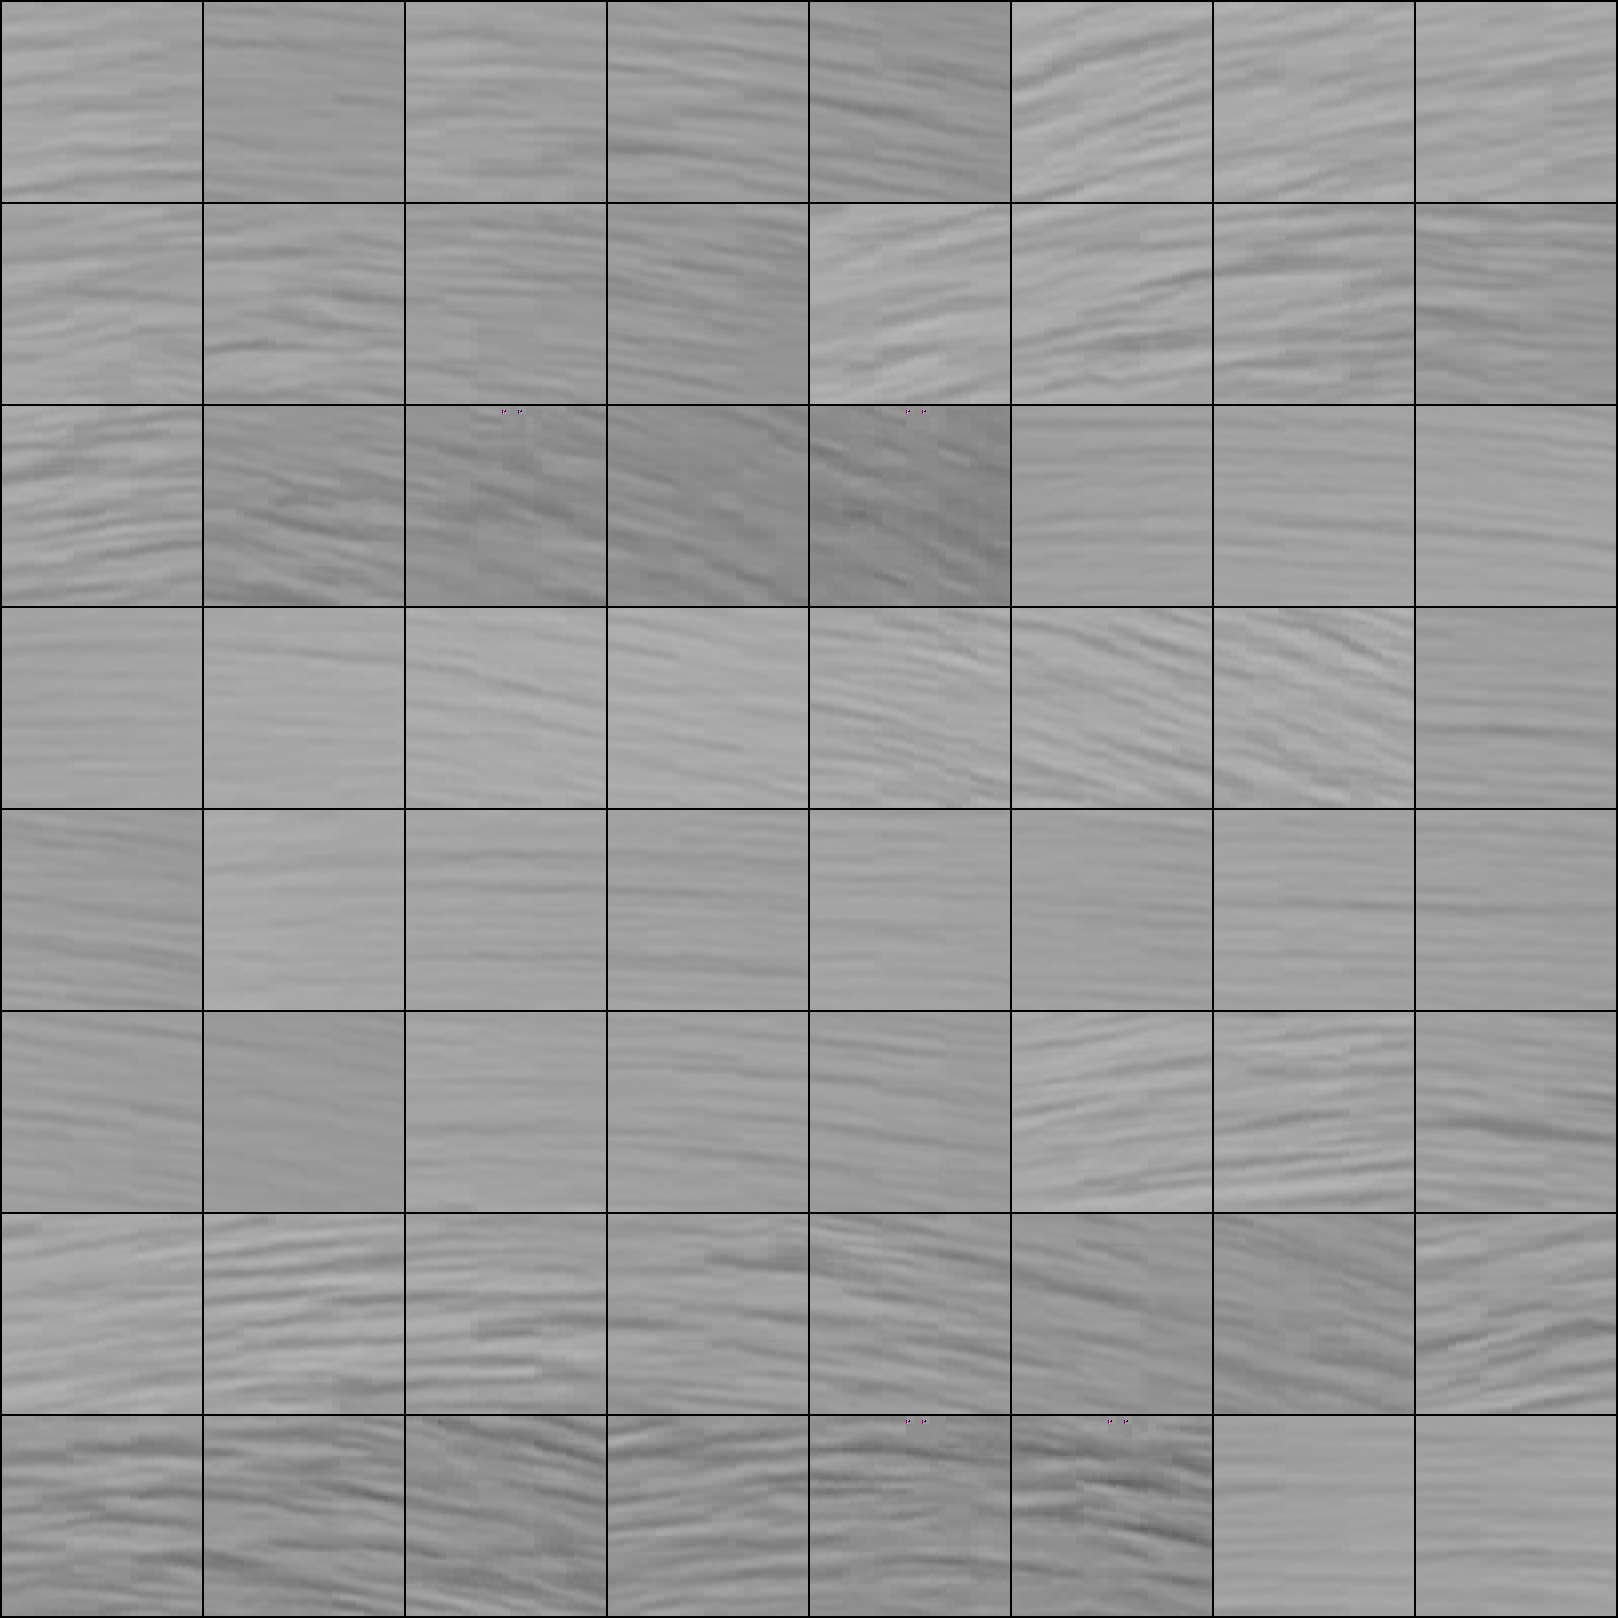

In [17]:
from PIL import Image
import glob
image_list = []
im=Image.open('C:/Users/NATAN/Desktop/FolderTest/Fiber/Reconstructed/Smaller_Train/image_1990.png')
im

# Testing

In [10]:
from IPython.display import Image
from IPython.core.display import Image, display

In [11]:
bs = 1
# Load Data
test_dataset = datasets.ImageFolder(root='./Fiber/Smaller_Test/Normal/Same_Pattern_Unseen', transform=transforms.Compose([
    transforms.ToTensor(), 
]))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=False)
len(test_dataset.imgs), len(test_dataloader)
test_dataset

Dataset ImageFolder
    Number of datapoints: 32
    Root location: ./Fiber/Smaller_Test/Normal/Same_Pattern_Unseen
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [12]:
len(test_dataloader)

32

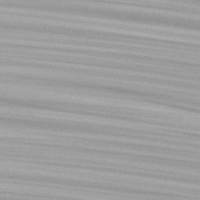

In [13]:
# Fixed input for debugging
fixed_test, _ = next(iter(test_dataloader))
save_image(fixed_test, 'smaller_test_pattern1_same_pattern.png')

Image('smaller_test_pattern1_same_pattern.png')

In [14]:
test= autoencoder()
test.to(device)

autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(128, 200, kernel_size=(2, 2), stride=(2, 2))
    (10): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(200, 200, kernel_size=(2, 2), stride=(2, 2))
    (13): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Conv2d(200, 200, kernel_size=(2, 2), stride=(2, 2))
    (16): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, tra

In [15]:
test.load_state_dict(torch.load('./autoencoder_fiber_smaller_pattern1.pth'))
test.eval()

autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(128, 200, kernel_size=(2, 2), stride=(2, 2))
    (10): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(200, 200, kernel_size=(2, 2), stride=(2, 2))
    (13): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Conv2d(200, 200, kernel_size=(2, 2), stride=(2, 2))
    (16): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, tra

In [16]:
for data in test_dataloader:
    img, _ = data
    img = Variable(img).cuda()
    # ===================forward=====================
    output = test(img)
    loss = criterion(output, img)
# ===================log========================
#     pic = to_img(output.cpu().data)
#     save_image(pic, './Fiber/Reconstructed/Smaller_Test/Same_Pattern_Unseen/image.png')
    print('loss:{:.4f}'.format(loss.data))
# tb.add_scalar("Loss", loss.data)


loss:0.0006
loss:0.0004
loss:0.0003
loss:0.0004
loss:0.0011
loss:0.0011
loss:0.0007
loss:0.0007
loss:0.0005
loss:0.0005
loss:0.0004
loss:0.0006
loss:0.0006
loss:0.0004
loss:0.0004
loss:0.0004
loss:0.0006
loss:0.0006
loss:0.0005
loss:0.0004
loss:0.0004
loss:0.0004
loss:0.0004
loss:0.0004
loss:0.0003
loss:0.0003
loss:0.0004
loss:0.0005
loss:0.0004
loss:0.0003
loss:0.0003
loss:0.0005


In [43]:
bs = 1
# Load Data
test_dataset = datasets.ImageFolder(root='./Fiber/Smaller_Test/Normal/Different_Pattern_Unseen', transform=transforms.Compose([
    transforms.ToTensor(), 
]))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=False)
len(test_dataset.imgs), len(test_dataloader)
test_dataset

Dataset ImageFolder
    Number of datapoints: 32
    Root location: ./Fiber/Smaller_Test/Normal/Different_Pattern_Unseen
    StandardTransform
Transform: Compose(
               ToTensor()
           )

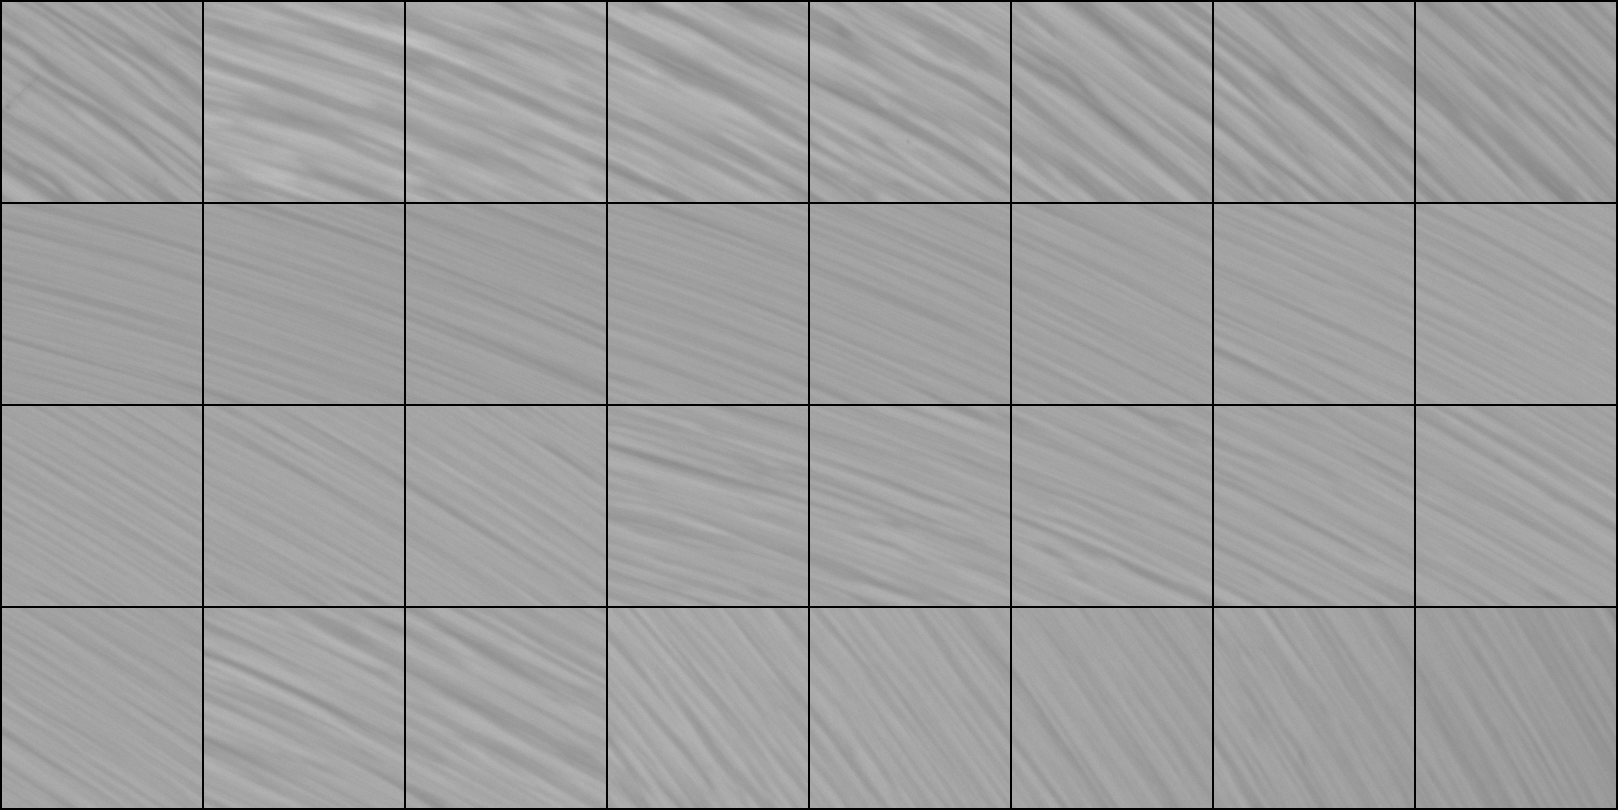

In [27]:
# Fixed input for debugging
fixed_test, _ = next(iter(test_dataloader))
save_image(fixed_test, 'smaller_test_pattern1_different_pattern.png')

Image('smaller_test_pattern1_different_pattern.png')

In [44]:
for data in test_dataloader:
    img, _ = data
    img = Variable(img).cuda()
    # ===================forward=====================
    output = test(img)
    loss = criterion(output, img)
# ===================log========================
    print('loss:{:.4f}'.format(loss.data))
# tb.add_scalar("Loss", loss.data)
#     pic = to_img(output.cpu().data)
#     save_image(pic, './Fiber/Reconstructed/Smaller_Test/Different_Pattern_Unseen/image.png')

loss:0.0011
loss:0.0016
loss:0.0013
loss:0.0018
loss:0.0012
loss:0.0017
loss:0.0012
loss:0.0010
loss:0.0003
loss:0.0004
loss:0.0004
loss:0.0004
loss:0.0003
loss:0.0004
loss:0.0004
loss:0.0003
loss:0.0003
loss:0.0005
loss:0.0004
loss:0.0006
loss:0.0007
loss:0.0005
loss:0.0005
loss:0.0005
loss:0.0004
loss:0.0011
loss:0.0009
loss:0.0007
loss:0.0006
loss:0.0006
loss:0.0005
loss:0.0005


In [45]:
bs = 1
# Load Data
test_dataset = datasets.ImageFolder(root='./Fiber/Smaller_Test/Abnormal/Damaged_by_hand', transform=transforms.Compose([
    transforms.ToTensor(), 
]))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=False)
len(test_dataset.imgs), len(test_dataloader)
test_dataset

Dataset ImageFolder
    Number of datapoints: 16
    Root location: ./Fiber/Smaller_Test/Abnormal/Damaged_by_hand
    StandardTransform
Transform: Compose(
               ToTensor()
           )

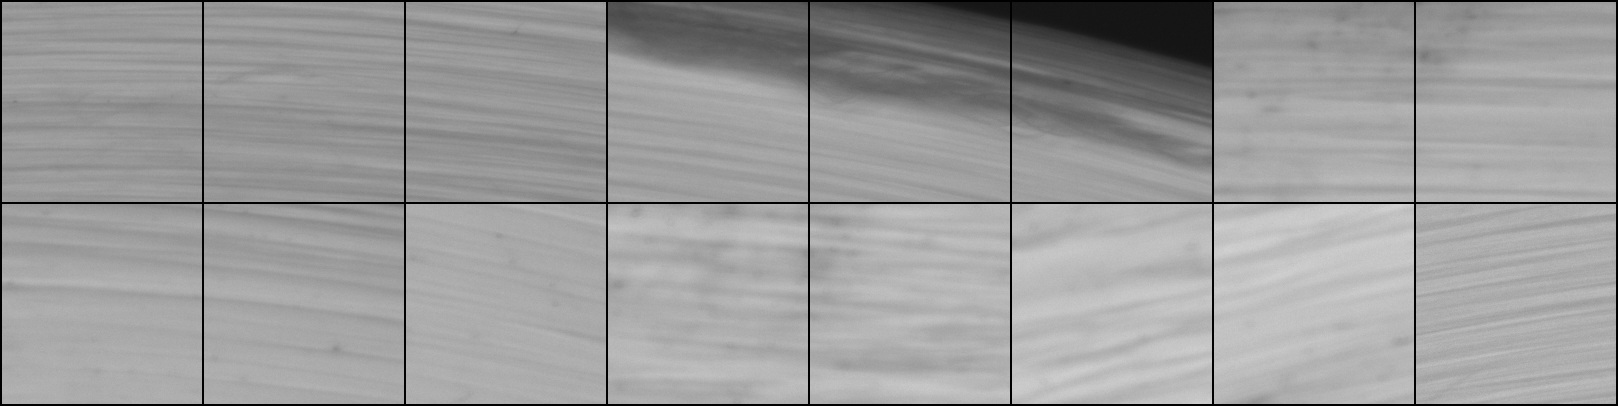

In [31]:
# Fixed input for debugging
fixed_test, _ = next(iter(test_dataloader))
save_image(fixed_test, 'smaller_test_pattern1_damaged_hand.png')

Image('smaller_test_pattern1_damaged_hand.png')

In [46]:
for data in test_dataloader:
    img, _ = data
    img = Variable(img).cuda()
    # ===================forward=====================
    output = test(img)
    loss = criterion(output, img)
# ===================log========================
    print('loss:{:.4f}'.format(loss.data))
# tb.add_scalar("Loss", loss.data)
# pic = to_img(output.cpu().data)
# save_image(pic, './Fiber/Reconstructed/Smaller_Test/Abnormal/damaged_hand.png')

loss:0.0007
loss:0.0011
loss:0.0010
loss:0.0148
loss:0.0223
loss:0.0558
loss:0.0020
loss:0.0019
loss:0.0009
loss:0.0012
loss:0.0004
loss:0.0011
loss:0.0011
loss:0.0015
loss:0.0022
loss:0.0007


In [47]:
bs = 1
# Load Data
test_dataset = datasets.ImageFolder(root='./Fiber/Smaller_Test/Abnormal/Gel', transform=transforms.Compose([
    transforms.ToTensor(), 
]))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=False)
len(test_dataset.imgs), len(test_dataloader)
test_dataset

Dataset ImageFolder
    Number of datapoints: 16
    Root location: ./Fiber/Smaller_Test/Abnormal/Gel
    StandardTransform
Transform: Compose(
               ToTensor()
           )

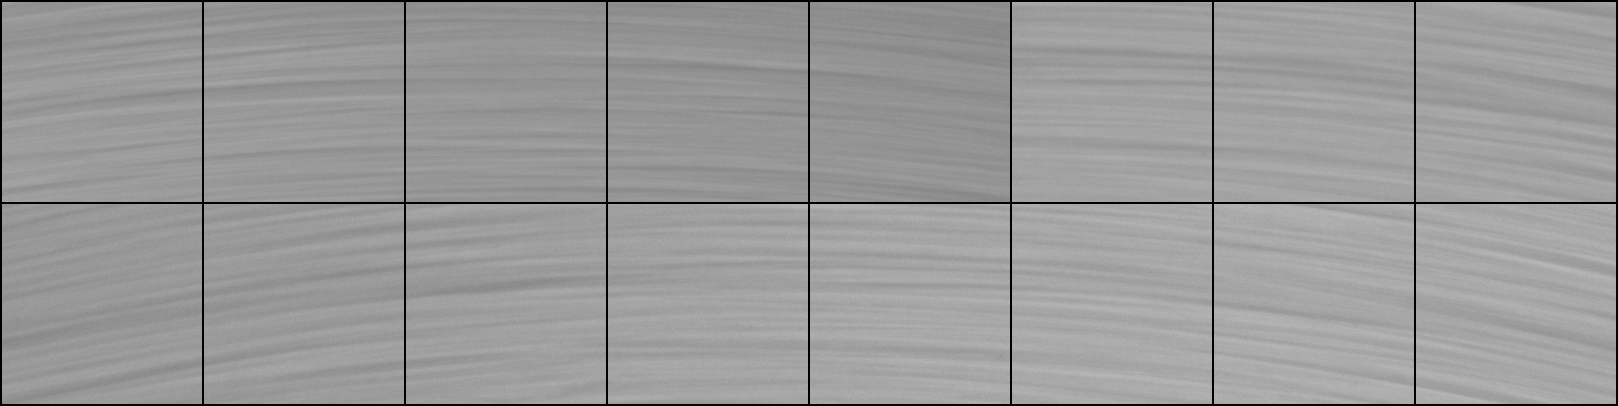

In [34]:
# Fixed input for debugging
fixed_test, _ = next(iter(test_dataloader))
save_image(fixed_test, 'smaller_test_pattern1_gel.png')

Image('smaller_test_pattern1_gel.png')

In [48]:
for data in test_dataloader:
    img, _ = data
    img = Variable(img).cuda()
    # ===================forward=====================
    output = test(img)
    loss = criterion(output, img)
# ===================log========================
    print('loss:{:.4f}'.format(loss.data))
# tb.add_scalar("Loss", loss.data)
# pic = to_img(output.cpu().data)
# save_image(pic, './Fiber/Reconstructed/Smaller_Test/Abnormal/gel.png')

loss:0.0005
loss:0.0005
loss:0.0005
loss:0.0007
loss:0.0007
loss:0.0004
loss:0.0004
loss:0.0005
loss:0.0006
loss:0.0005
loss:0.0005
loss:0.0004
loss:0.0005
loss:0.0005
loss:0.0006
loss:0.0009


In [49]:
bs = 1
# Load Data
test_dataset = datasets.ImageFolder(root='./Fiber/Smaller_Test/Abnormal/Machine_Stain', transform=transforms.Compose([
    transforms.ToTensor(), 
]))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=False)
len(test_dataset.imgs), len(test_dataloader)
test_dataset

Dataset ImageFolder
    Number of datapoints: 16
    Root location: ./Fiber/Smaller_Test/Abnormal/Machine_Stain
    StandardTransform
Transform: Compose(
               ToTensor()
           )

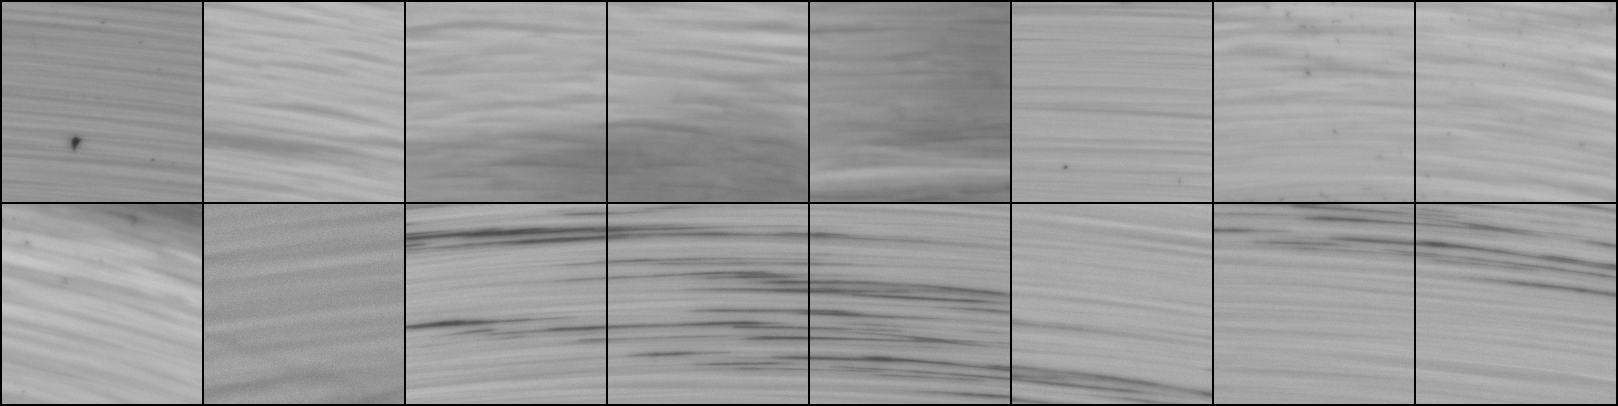

In [37]:
# Fixed input for debugging
fixed_test, _ = next(iter(test_dataloader))
save_image(fixed_test, 'smaller_test_pattern1_machine_stain.png')

Image('smaller_test_pattern1_machine_stain.png')

In [50]:
for data in test_dataloader:
    img, _ = data
    img = Variable(img).cuda()
    # ===================forward=====================
    output = test(img)
    loss = criterion(output, img)
# ===================log========================
    print('loss:{:.4f}'.format(loss.data))
# tb.add_scalar("Loss", loss.data)
# pic = to_img(output.cpu().data)
# save_image(pic, './Fiber/Reconstructed/Smaller_Test/Abnormal/machine_stain.png')

loss:0.0010
loss:0.0022
loss:0.0073
loss:0.0096
loss:0.0034
loss:0.0005
loss:0.0011
loss:0.0010
loss:0.0041
loss:0.0010
loss:0.0055
loss:0.0044
loss:0.0039
loss:0.0028
loss:0.0022
loss:0.0026
